# Importing Relevant Libraries

In [1]:
#Mathematical Libraries
import numpy as np
import mpmath as mp 
import math
from decimal import Decimal as D

#Scipy
import scipy.special as sc
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

#Plotting Library
import matplotlib.pyplot as plt
import matplotlib

#Miscellaneous Libraries
import time
from IPython.display import clear_output
import csv
import copy


# Class Definitions

In [2]:
#~~~~~~~~~~~~~~~~~~~~~Class definition: PopIII stars~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


class PopIIIStar:
    '''Describes important parameters of a population III star,
    Units:
            M - Solar
            R - Solar
            L - Solar
            Tc - Kelvin (K)
            rhoc - g/cm^3
            life_star - years'''
    def __init__(self, M = 0, R = 0, L = 0, Tc = 0, rhoc = 0, life_star = 0):
        self.mass = M
        self.radius = R
        self.lum = L
        self.core_temp = Tc
        self.core_density = rhoc
        self.lifetime = life_star
        
    #Calculates stellar volume
    def get_vol(self):
        vol = (4/3) * np.pi * (self.radius*6.96e10)**3 #in cm^3
        
        return vol
    
    def get_num_density(self):
        mn_grams = 1.6726e-24
        M = 1.9885e33 * self.mass
        
        n_baryon = 0.75*M/mn_grams * 1/(self.get_vol())
        
        return n_baryon
    
    def get_mass_grams(self):
        M_gram = 1.9885e33 * self.mass
        return M_gram
    
    def get_radius_cm(self):
        R_cm = self.radius*6.96e10
        return R_cm
    
    def get_vesc_surf(self):
        G  = 6.6743*10**(-8) #cgs units
        M = self.get_mass_grams()
        R = self.get_radius_cm()
        Vesc = np.sqrt(2*G*M/R) # escape velocity(cm/s) 
        return Vesc

# 100, 300, and 1000 Solar Mass Pop III Parameters

In [3]:
#Stellar params
M100 = PopIIIStar(100, 10**0.6147, 10**6.1470, 1.176e8, 32.3, 10**6)
M300 = PopIIIStar(300, 10**0.8697, 10**6.8172, 1.245e8, 18.8, 10**6)
M1000 = PopIIIStar(1000, 10**1.1090, 10**7.3047, 1.307e8, 10.49, 10**6)
stars_list = (M100, M300, M1000)

In [4]:
######################### CORRECT FUNCTIONS FOR POLYTROPES ###############################################################

#Retrieves solution to laneEmden n=3 
def retrieve_LaneEmden():
    xis = []
    theta_arr = []
    with open('Lane_Emden.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            xis.append(float(row[0]))
            theta_arr.append(float(row[1]))
            
    return (xis, theta_arr)


#Retrieves tau(mx) from stored data
def retrieve_tau(star):
    mx = []
    tau = []
    with open('tau_mx_M%i.csv'%star.mass) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            mx.append(float(row[0]))
            tau.append(float(row[1]))
            
    return (mx, tau)

tau_fit_funcs = []
#Tau fits and function that will give output based on mx and star
for star in stars_list:
    mx_tau_fit, tau_temp = retrieve_tau(star)
    tau_fit_funcs.append(UnivariateSpline(mx_tau_fit, tau_temp, k = 5, s = 0))

def tau_fit(mx, star): #Returns tau from fitting function based on star and dm mass
    if(mx > 100):
        tau_val = 1
    else:
        if(star.mass == 100):
            tau_val = tau_fit_funcs[0](mx)
        elif(star.mass == 300):
            tau_val = tau_fit_funcs[1](mx)
        elif(star.mass == 1000):
            tau_val = tau_fit_funcs[2](mx)
        else:
            tau_val = 1
    return tau_val
    


# Solution to laneEmden Equation
xis, theta_arr = retrieve_LaneEmden()
# interpolating points for theta function
theta = UnivariateSpline(xis, theta_arr, k = 5, s = 0)


#Density at center of polytrope
def polytrope3_rhoc(star):
    
    #Getting stellar params
    Mstar = star.get_mass_grams() #grams
    Rstar = star.get_radius_cm()  #cm
    
    #x-intercept of the theta function
    xi_1 = xis[-1]

    #Slope of laneEmden at Theta = 0
    deriv_xi1 = theta.derivatives(xis[-1])[1]  
    
    #Central polytropic density as per n=3 polytropic model
    rhoc_poly = (-1/(4*np.pi)) * ((xi_1/Rstar)**3) * (Mstar/(xi_1**2)) * (deriv_xi1)**-1 #g/cm^3
    
    return rhoc_poly





#Polytropic potential
def potential_poly(xi, star):
    G = 6.6743*10**(-8) # gravitational constant in cgs units
    
    phi_xi = 4*np.pi*G*(polytrope3_rhoc(star))*(star.get_radius_cm()/xis[-1])**2 * (1 - theta(xi)) #cgs units
    
    return phi_xi




#Isotropic DM distribution using potential from n=3 polytrope
def nx_xi(mx, xi, star): #Normalized
    
    kb = 1.380649e-16 #Boltzmann constant in cgs Units (erg/K)
    
    #Finding Tx using Temperature function
    Tx = tau_fit(mx, star) * 10**8 #K

    #mx in g
    mx_g = mx*1.783e-24
    
    #Numerical DM number density profile for each DM mass (normalized)
    nx_xi_val = np.exp(-mx_g*potential_poly(xi, star)/(kb*Tx)) 
    
    return nx_xi_val





#Defining integrand for effective volumes
def integrand_Vj_poly3(xi, j, mx, star):
    return xi**2 * (nx_xi(mx, xi, star))**j
#Numerically integrating to get effective volumes for polytropes
def Vj_poly3(j, mx, star):
    xi_1 = xis[-1]
    factor = 4*np.pi*(star.get_radius_cm()/xi_1)**3 #Outside integral factor
    int_val = quad(integrand_Vj_poly3, 0, xi_1, args=(j, mx, star)) #Integrate nx/nc * xi**2 over star
    Vj = factor * int_val[0] #cm^3
    return Vj




# K factor for correcting bounds on sigv (due to breakdown in the assumption of n_c = nc_bar)
# NOT CURRENTLY USING, I AM DOING FULL NUMERICAL INTEGRATION INSTEAD
def k_factor(mx):
    
    #Dimensionless DM mass
    mu = mx/0.93827
    #Dimensionless DM temperature
    tau = tau_fit(mx, star)
    
    #Finding the first 0 of lane-emden 'xi_1'
    xi_1 = xis[-1]
    
    #Calculate "B" function that appears in exponents for the calculation of K constant
    B = 8*mu/tau * (1 - np.array(theta_arr))
    
    #Calculating integrands and using interpolating fnctions to fit them for ease of integration
    integrand_top = np.multiply(np.multiply(np.array(xis)**2, np.exp(-B)) ,np.array(theta_arr)**3 )
    integrand_bottom = np.multiply(np.array(xis)**2, np.exp(-B))
    integrandTop_spl = UnivariateSpline(xis, integrand_top, k = 5, s = 0)
    integrandBottom_spl = UnivariateSpline(xis, integrand_bottom, k = 5, s = 0)
    
    #Calculating K
    K = xi_1**3/6 * integrandTop_spl.integral(0, xi_1)/integrandBottom_spl.integral(0, xi_1)
    
    return K




### Evaporation Functions

<ipython-input-12-99e0e04695c5>:276: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  palette.set_over('white')
<ipython-input-12-99e0e04695c5>:277: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  palette.set_under('white')
<ipython-input-12-99e0e04695c5>:295: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading

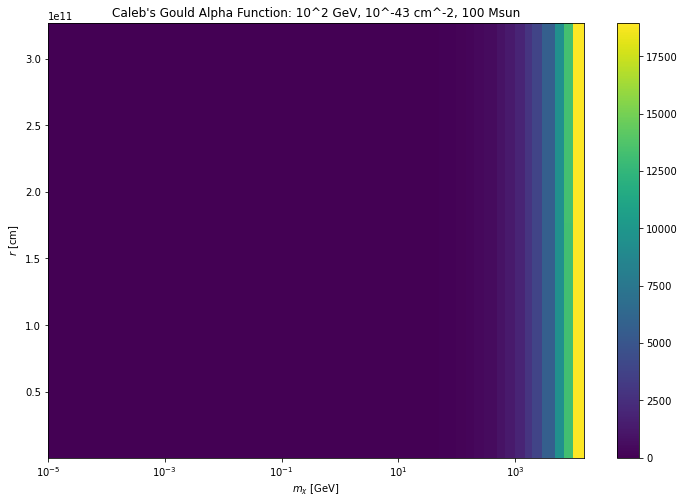

In [12]:

#FITTING FUNCTION FOR theta**3
theta_cube = UnivariateSpline(xis, np.array(theta_arr)**3, k = 5, s = 0)


#Escape velocity of n=3 polytrope at given radius (dimensionless xi)
def vesc_r_poly(xi, star):
    G = 6.6743*10**(-8) # gravitational constant in cgs units
    
    xi1 =  xis[-1]

    vesc_xi = np.sqrt( 2*G*star.get_mass_grams()/star.get_radius_cm() + 2*(potential_poly(xi1, star) - potential_poly(xi, star)) )
    
    return vesc_xi/star.get_vesc_surf()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




## Mu Functions ##
def mu(mx):#take mx in GeV
    mu_val = mx/0.93827
    return mu_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~





def mu_plus_minus(plus_minus, mx):
    if(plus_minus == '+'):
        mu_plus_val = (mu(mx) + 1)/2
    elif(plus_minus == '-'):
        mu_plus_val = (mu(mx) - 1)/2
    return mu_plus_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~






#l(r), most probable dimensionless velocity of protons at specific point in star
def proton_speed(xi, star):
    kb = 1.380649e-16 #Boltzmann constant in cgs Units (erg/K)
    Tc = 10**8 #Central star temperature taken to be ~ 10^8 K

    u = np.sqrt(2*kb*Tc*theta(xi)/1.6726219e-24) #cm/s (cgs units)
    
    l = u/star.get_vesc_surf()
    
    return l
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~






## Alpha/Beta Functions ##
def alpha(plus_minus, mx, q, z, xi, star):
    l = proton_speed(xi, star)
    if (plus_minus == '+'):
        alpha_val = (mu_plus_minus('+', mx)*q + mu_plus_minus('-', mx)*z)/l
    elif(plus_minus == '-'):
        alpha_val = (mu_plus_minus('+', mx)*q - mu_plus_minus('-', mx)*z)/l
        
    return alpha_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


def beta(plus_minus, mx, q, z, xi, star):
    l = proton_speed(xi, star)
    if (plus_minus == '+'):
        beta_val = (mu_plus_minus('-', mx)*q + mu_plus_minus('+', mx)*z)/l
    elif(plus_minus == '-'):
        beta_val = (mu_plus_minus('-', mx)*q - mu_plus_minus('+', mx)*z)/l
        
    return beta_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~





## Chi Function ##
def chi_func(a,b):
    chi_val = np.sqrt(np.pi)/2 * (mp.erf(b) - mp.erf(a))
    return chi_val

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 
    
    
    
#Number density of proton distribution in n = 3 polytrope
def eta_proton(xi):    
    eta_xi = theta_cube(xi)
    
    return eta_xi

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~





#R_+ coefficient
def R_plus(q, z, mx, xi, sigma, star):
    
    #Dimensionless Quantities
    mu_val = mu(mx)
    mu_plus = mu_plus_minus('+', mx)
    eta = eta_proton(xi)
    alpha_minus = alpha('-', mx, q, z, xi, star)
    alpha_plus = alpha('+', mx, q, z, xi, star)
    beta_minus = beta('-', mx, q, z, xi, star)
    beta_plus = beta('+', mx, q, z, xi, star)
    chi_alpha = chi_func(alpha_minus, alpha_plus)
    chi_beta = chi_func(beta_minus, beta_plus)
    l = proton_speed(xi, star)
    
    #Central proton number density (cm^-3)
    nc = polytrope3_rhoc(star)*0.75/1.6726e-24
    
    #R_plus calculation
    R_plus_val = 2*nc/np.sqrt(np.pi) * mu_plus**2/mu_val * q/z * eta * sigma * (chi_alpha + chi_beta*mp.exp(mu_val * (z**2 - q**2)/(l**2))) # cm^-1
    
    return R_plus_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



#R_- coefficient
def R_minus(q, z, mx, xi, sigma, star):
    
    #Dimensionless Quantities
    mu_val = mu(mx)
    mu_plus = mu_plus_minus('+', mx)
    eta = eta_proton(xi)
    alpha_minus = alpha('-', mx, q, z, xi, star)
    alpha_plus = alpha('+', mx, q, z, xi, star)
    beta_minus = beta('-', mx, q, z, xi, star)
    beta_plus = beta('+', mx, q, z, xi, star)
    chi_alpha = chi_func(-1*alpha_minus, alpha_plus)
    chi_beta = chi_func(-1*beta_minus, beta_plus)
    l = proton_speed(xi, star)
    
    #Central proton number density (cm^-3)
    nc = polytrope3_rhoc(star)*0.75/1.6726e-24
    
    #R_plus calculation
    R_minus_val = 2*nc/np.sqrt(np.pi) * mu_plus**2/mu_val * q/z * eta * sigma * (chi_alpha + chi_beta*mp.exp(mu_val * (z**2 - q**2)/(l**2))) # cm^-1
        
    return R_minus_val

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




#Omega_plus function, integral over R_plus
def omega_plus(z, mx, xi, sigma, star):
    vesc = star.get_vesc_surf()
    
    omega_plus_val = vesc * mp.quad(lambda q: R_plus(q, z, mx, xi, sigma, star), [vesc_r_poly(xi, star), np.inf]) #s^-1
    
    return omega_plus_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



#Omega function, integral over R_plus + Rminus
def omega(z, mx, xi, sigma, star):
    vesc = star.get_vesc_surf()
    
    
    omega_val = vesc * ( mp.quad(lambda q: R_minus(q, z, mx, xi, sigma, star), [vesc_r_poly(xi, star), z]) + mp.quad(lambda q: R_plus(q, z, mx, xi, sigma, star), [z, np.inf]) ) #s^-1
    
    return omega_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~






#Average dm speed in star (isotropic)
def dm_speed(mx, star):
    kb = 1.380649e-16 #Boltzmann constant in cgs Units (erg/K)
    Tx = tau_fit(mx, star) * 10**8 #DM temperature
    mx_g = mx * 1.783e-24 #Converting GeV/c^2 to g

    
    vx = np.sqrt(2*kb*Tx/mx_g) #cm/s
    
    ux = vx/star.get_vesc_surf() #Dimensionless
    
    return ux
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




def f_x(z, mx, xi, star):
    
    #Dm dimensionless speed
    ux = dm_speed(mx, star)
    ue_xi = vesc_r_poly(xi, star)
    vesc = star.get_vesc_surf()
    
    
    f_x_val = np.exp(-z**2/ux**2) * ( np.pi**(3/2) * ux**3 * vesc**3 * (sc.erf(ue_xi/ux) - 2/np.sqrt(np.pi)*ue_xi/ux*np.exp(-ue_xi**2/ux**2) )  )**-1

    
    return f_x_val
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def f_x_inf(z, mx, xi, star):
    
    #Dm dimensionless speed
    ux = dm_speed(mx, star)
    vesc = star.get_vesc_surf()
    
    
    f_x_val = mp.exp(-z**2/ux**2) * ( np.pi**(3/2) * ux**3 * vesc**3 )**-1

    
    return f_x_val



def integrand(z, mx, xi, sigma, star, vcut_inf = False):
    return f_x(z, mx, xi, star)*omega_plus(z, mx, xi, sigma, star)*z**2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def integrand_inf(z, mx, xi, sigma, star, vcut_inf = False):
    return f_x_inf(z, mx, xi, star)*omega(z, mx, xi, sigma, star)*z**2




def R_integrated(mx, xi, sigma, star, vcut_inf = False):
    vesc = star.get_vesc_surf()
    if(vcut_inf == False):
        R = 4*np.pi * vesc**3 * quad(integrand, 0, vesc_r_poly(xi, star), args=(mx, xi, sigma, star, vcut_inf))[0]
    else:
        R = 4*np.pi * vesc**3 * mp.quad(lambda z: integrand_inf(z, mx, xi, sigma, star, vcut_inf), [0, np.inf])
    
    return R
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




def upper_integrand(xi, mx, sigma, star, vcut_inf = False):
    return xi**2 * nx_xi(mx, xi, star) * R_integrated(mx, xi, sigma, star, vcut_inf)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def lower_integrand(xi, mx, sigma, star):
    return xi**2 * nx_xi(mx, xi, star)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


def evap_coeff(mx, sigma, star, vcut_inf = False):
    xi1 = xis[-1]
    E = quad(upper_integrand, 0, xi1, args=(mx, sigma, star, vcut_inf))[0]/quad(lower_integrand, 0, xi1, args=(mx, sigma, star))[0]
    
    return E
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ploting stuff
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')
palette.set_over('white')
palette.set_under('white')


# CALEB LOOK HERE!!!

# an array of masses in GeV to try
m_chi_sample = [0.00001, 0.000015, 0.00002, 0.00003, 0.00005, 0.00007, 0.0001, 0.00015, 0.0002, 0.0003, 0.0005, 0.0007, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5, 7, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 5000, 7000, 10000, 15000]

# an array of 25 raddii in cm
r = [4.53782922 * 10**8, 1.40590696*10**10, 2.76643563*10**10, 4.12696430*10**10, 5.48749297*10**10, 6.84802164*10**10, 8.20855030*10**10, 9.56907897*10**10, 1.09296076*10**11, 1.22901363*10**11, 1.36506650*10**11, 1.50111936*10**11, 1.63717223*10**11, 1.77322510*10**11, 1.90927797*10**11, 2.04533083*10**11, 2.18138370*10**11, 2.31743657*10**11, 2.45348943*10**11, 2.58954230*10**11, 2.72559517*10**11, 2.86164803*10**11, 2.99770090*10**11, 3.13375377*10**11, 3.26980663*10**11]

caleb_alpha_sample = np.zeros([len(r), len(m_chi_sample)])

for i in range(len(r)):
    for j in range(len(m_chi_sample)):
        #print("Calculating alpha, i = ", i, "/", len(r), ", j = ", j, "/", len(m_chi_sample_cgs))
        # alpha(pm, mass of dark matter, starting velocity, ending velocity, xi, star)
        caleb_alpha_sample[i,j] = alpha("+", m_chi_sample[j], 0.5, 1, r[i]/(6.89*r[-1]), M100)
plt.pcolormesh(m_chi_sample, r, caleb_alpha_sample, cmap=palette)
cbar = plt.colorbar()
# cbar.set_label('$\\log_{10} (\\rho_{plat.}/$ GeV cm$^{-3})$', fontsize = 13)
# cbar.set_ticks(list(np.linspace(9, 19, 11)))
plt.title("Caleb's Gould Alpha Function: 10^2 GeV, 10^-43 cm^-2, 100 Msun")
# plt.legend()
plt.ylabel('$r$ [cm]')
# plt.ylim([0, 1.2*10**17])
plt.xlabel("$m_{\chi}$ [GeV]")
# plt.yscale("log")
plt.xscale("log")

plt.savefig("caleb_alpha4.png")




#### Gould Evap Functions

In [ ]:
def omega_gould(z, mx, xi, sigma, star):
    #Central proton number density (cm^-3)
    nc = polytrope3_rhoc(star)*0.75/1.6726e-24
    
    a_plus = alpha('+', mx, vesc_r_poly(xi, star), z, xi, star)
    a_minus = alpha('-', mx, vesc_r_poly(xi, star), z, xi, star)
    
    b_plus = beta('+', mx, vesc_r_poly(xi, star), z, xi, star)
    b_minus = beta('-', mx, vesc_r_poly(xi, star), z, xi, star)
    
    #Pre factor for Omega in Gould using my notation
    omega_pre = (2*np.pi**(1/2))**-1 * (proton_speed(xi, star)/mu(mx))**2 * sigma*star.get_vesc_surf()/z * nc * eta_proton(xi)
    
    #Omega
    omega_val = omega_pre * (    mu(mx)*(a_plus*np.exp(-a_minus**2) - a_minus*np.exp(-a_plus**2)) + chi_func(a_minus, a_plus)*(mu(mx) - 2*mu(mx)*a_minus*a_plus - 2*mu_plus_minus('+', mx)*mu_plus_minus('-', mx)) + 2*mu_plus_minus('+', mx)**2 * chi_func(b_minus, b_plus)*np.exp( mu(mx)*(z**2 - vesc_r_poly(xi, star)**2)/proton_speed(xi, star)**2 )    )
    
    
    return omega_val


def nu_gould(mx, xi, star):
    return theta(xi)*mu(mx)/tau_fit(mx, star)

def xi_gould(mx, xi, star):
    return np.sqrt(mu_plus_minus('-', mx)**2 + nu_gould(mx, xi, star))

def rho_gould(mx, xi, star):
    return mu_plus_minus('+', mx)*mu_plus_minus('-', mx)/xi_gould(mx, xi, star)

def E_e_gould(mx, xi, star):
    return mx*1.783e-24*(vesc_r_poly(xi, star) * star.get_vesc_surf())**2 / 2

def E_c_gould(mx, xi, star):
    return E_e_gould(mx, xi, star)

def gamma_gould(pm, mx, xi, star):
    if (pm == '+'):
        ret_val = vesc_r_poly(xi, star)/proton_speed(xi, star)*(rho_gould(mx, xi, star) + xi_gould(mx, xi, star))
    else:
        ret_val = vesc_r_poly(xi, star)/proton_speed(xi, star)*(rho_gould(mx, xi, star) - xi_gould(mx, xi, star))
    return ret_val

def normalize_factor(mx, xi, star):
    ux = dm_speed(mx, star)
    ue_xi = vesc_r_poly(xi, star)    
    
    ret_val =  (sc.erf(ue_xi/ux) - 2/np.sqrt(np.pi)*ue_xi/ux*np.exp(-ue_xi**2/ux**2) )**-1 
    
    return ret_val

def R_gould(mx, xi, sigma, star):
    #Central proton number density (cm^-3)
    nc = polytrope3_rhoc(star)*0.75/1.6726e-24
    
    kb = 1.380649e-16 #Boltzmann constant in cgs Units (erg/K)
    
    T = (10**8) * theta(xi)
    Tx = tau_fit(mx, star) * 10**8
    mu_p = mu_plus_minus('+', mx)
    mu_m = mu_plus_minus('-', mx)
    nu = nu_gould(mx, xi, star)
    xi_g = xi_gould(mx, xi, star)
    Ee = E_e_gould(mx, xi, star)
    Ec = E_c_gould(mx, xi, star)
    g_p = gamma_gould('+', mx, xi, star)
    g_m = gamma_gould('-', mx, xi, star)
    a_p = alpha('+', mx, vesc_r_poly(xi, star), vesc_r_poly(xi, star), xi, star)
    a_m = alpha('-', mx, vesc_r_poly(xi, star), vesc_r_poly(xi, star), xi, star)
    b_p = beta('+', mx, vesc_r_poly(xi, star), vesc_r_poly(xi, star), xi, star)
    b_m = beta('-', mx, vesc_r_poly(xi, star), vesc_r_poly(xi, star), xi, star)
    
    R_pre = 2/np.pi * proton_speed(xi, star) * star.get_vesc_surf() * 1/np.sqrt(mu(mx)) * (T/Tx)**(3/2) * sigma * nc * eta_proton(xi)
    
    term1 = np.exp(-(mu_p/xi_g)**2 * (Ee/(kb*Tx))) * (mu(mx)*mu_m/(nu*xi_g)*(xi_g**2/nu - mu_p*mu_m/mu(mx)) + mu_p**3/(xi_g*(nu-mu(mx))))*chi_func(g_m, g_p) 
    
    term2 = np.exp(-Ec/(kb*Tx)) * mu(mx)/nu * ( a_p*a_m - 1/(2*mu(mx)) + mu_m**2*(1/mu(mx) - 1/nu) ) * chi_func(a_m, a_p)
    
    term3 = np.exp(-Ec/(kb*Tx)) * np.exp(-(Ee-Ec)/(kb*T)) * mu_p**2/(nu - mu(mx)) * chi_func(b_m, b_p)
    
    term4 = np.exp(-(Ec/(kb*Tx) + a_m**2)) * mu(mx)*a_p/(2*nu)
    
    term5 = np.exp(-(Ec/(kb*Tx) + a_p**2)) * mu(mx)*a_m/(2*nu)
    
    R_val = R_pre * (term1 + term2 - term3 - term4 + term5) * normalize_factor(mx, xi, star)
    
    return R_val



def R_gould_approx(mx, xi, sigma, star):

    #Central proton number density (cm^-3)
    n = polytrope3_rhoc(star)*0.75/1.6726e-24 * theta(xi)**3
    
    u = proton_speed(xi, star)
    
    R_val = 2*np.pi**(-1/2)*sigma*n*u*star.get_vesc_surf()*np.exp( -(vesc_r_poly(xi, star)/dm_speed(mx, star))**2 )

    
    return R_val


def upper_integrand_G(xi, mx, sigma, star):
    return xi**2 * nx_xi(mx, xi, star) * R_gould(mx, xi, sigma, star)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def lower_integrand_G(xi, mx, sigma, star):
    return xi**2 * nx_xi(mx, xi, star)

def evap_coeff_G(mx, sigma, star):
    xi1 = xis[-1]
    E = quad(upper_integrand_G, 0, xi1, args=(mx, sigma, star))[0]/quad(lower_integrand_G, 0, xi1, args=(mx, sigma, star))[0]
    
    return E

def upper_integrand_G_approx(xi, mx, sigma, star):
    return xi**2 * nx_xi(mx, xi, star) * R_gould_approx(mx, xi, sigma, star)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def lower_integrand_G_approx(xi, mx, sigma, star):
    return xi**2 * nx_xi(mx, xi, star)

def evap_coeff_G_approx(mx, sigma, star):
    xi1 = xis[-1]
    E = quad(upper_integrand_G_approx, 0, xi1, args=(mx, sigma, star))[0]/quad(lower_integrand_G_approx, 0, xi1, args=(mx, sigma, star))[0]
    
    return E



def evap_coeff_Ilie_approx(mx, sigma, star):
    #Central proton number density (cm^-3)
    nc = polytrope3_rhoc(star)*0.75/1.6726e-24
    
    uc = proton_speed(xis[0], star)
    
    vesc = 1
    vesc_val = star.get_vesc_surf()
    
    tau = tau_fit(mx, star)
    mu = mx/0.93827
    
    xi1 = xis[-1]
    E = 9/np.sqrt(np.pi) * 1/(xi1**3) * sigma * nc * uc *vesc_val * np.exp(-vesc**2/uc**2 * mu/tau)
    
    return E

def evap_coeff_Ilie_approx2(mx, sigma, star):
    #Central proton number density (cm^-3)
    nc = polytrope3_rhoc(star)*0.75/1.6726e-24
    
    xi1 = xis[-1]

    
    uc = proton_speed(xis[0], star)
    
    vesc = 1
    vesc_val = star.get_vesc_surf()
    
    tau = tau_fit(mx, star)
    mu = mx/0.93827
    
    xi1 = xis[-1]
    E = 9/np.sqrt(np.pi) * 1/(xi1**3) * sigma * nc * uc *vesc_val * np.exp(-vesc**2/uc**2 * mu/tau * (1 + xis[-1]/2)) * star.get_vol()/Vj_Eff_SP(star,mx , 1)
    
    return E

    


### Tau_Equilibirum

In [ ]:
#Annihilation coefficient -- 2DM + 1SM
def Ca_321(mx, star):
    #sigv^2 given by thermal freezeout
    sigv = 10**3/(mx**3)
    sigv_cg = sigv * (1.52e24) * (5.06e13)**(-6) #Convert to cm^6/s
    
    #Defining top and bottom integrands using Fully polytropic approximation
    def integrand_top_Ca(xi, mx, star):
        return 4*np.pi*(star.get_radius_cm()/xis[-1])**3 * (polytrope3_rhoc(star)*0.75/1.6726e-24) * sigv_cg * xi**2 * nx_xi(mx, xi, star)**2 * theta(xi)**3
    def integrand_bottom_Ca(xi, mx, star):
        return 4*np.pi*(star.get_radius_cm()/xis[-1])**3 * xi**2 * nx_xi(mx, xi, star)
    
    return quad(integrand_top_Ca, 0, xis[-1], args=(mx, star))[0]/quad(integrand_bottom_Ca, 0, xis[-1], args=(mx, star))[0]**2
 
    
    
#Equilibration timescale -- 2DM + 1SM interactions
def tau_eq_321(mx, star, rho_chi, vbar, sigma_xenon = False):
    #Switch for which sigma to use
    if (sigma_xenon == True):
        sigma = 1.26*10**(-40)*(mx/10**8)
    else:
        sigma = sigma_xenon
        
    #Calculating the DM capture rate
    C = float(captureN_pureH(star, mx, rho_chi, vbar, sigma)[1])
    
    #Annihlation coefficient
    Ca = Ca_321(mx, star)
    
    #Equilibration timescale
    tau_eq = (C * Ca)**(-1/2)
    
    return tau_eq
    
    

#Annihilation coefficient -- 2-->2
def Ca_22(mx, star, rho_chi, vbar, sigma):
    #sigv given by lower bounds
    sigv = sigV_lowerBound(star, 0.01, mx, rho_chi, vbar, sigma, 22)
    
    #Defining top and bottom integrands using Fully polytropic approximation
    def integrand_top_Ca(xi, mx, star):
        return 4*np.pi*(star.get_radius_cm()/xis[-1])**3 * sigv * xi**2 * nx_xi(mx, xi, star)**2
    def integrand_bottom_Ca(xi, mx, star):
        return 4*np.pi*(star.get_radius_cm()/xis[-1])**3 * xi**2 * nx_xi(mx, xi, star)
    
    return quad(integrand_top_Ca, 0, xis[-1], args=(mx, star))[0]/quad(integrand_bottom_Ca, 0, xis[-1], args=(mx, star))[0]**2



#Equilibration timescale -- 2-->2
def tau_eq_22(mx, star, rho_chi, vbar, sigma_xenon = False):
    #Switch for which sigma to use
    if (sigma_xenon == True):
        sigma = 1.26*10**(-40)*(mx/10**8)
    else:
        sigma = sigma_xenon
        
    #Calculating the DM capture rate
    C = float(captureN_pureH(star, mx, rho_chi, vbar, sigma)[1])
    
    #Annihlation coefficient
    Ca = Ca_22(mx, star, rho_chi, vbar, sigma)
    
    #Equilibration timescale
    tau_eq = (C * Ca)**(-1/2)
    
    return tau_eq

### Sigma-Mx, Fsolve

In [ ]:
def kappa_evap321(mx, sigma, star, rho_chi, vbar):
    E = evap_coeff_Ilie_approx2(mx, sigma, star)
    tau_eq = tau_eq_321(mx, star, rho_chi, vbar, sigma)
    
    kap = (1 + (E*tau_eq/2)**2)**(1/2)
    
    return kap


def kappa_evap22(mx, sigma, star, rho_chi, vbar):
    E = evap_coeff_Ilie_approx2(mx, sigma, star)
    tau_eq = tau_eq_22(mx, star, rho_chi, vbar, sigma)
    
    kap = (1 + (E*tau_eq/2)**2)**(1/2)
    
    return kap


def sigma_mx_pureH_fsolve_cap(mx, star, rho_chi, vbar):
    
    def LHS(sigma, mx, star, rho_chi, vbar):
        #Fraction of annihilations in luminosity
        f = 1

        #Solar luminosity in erg/s
        Lsun       = 3.846e33;

        #Convert luminosity to erg/s from solar luminosities
        L = star.lum*Lsun

        #Convert DM mass to Ergs
        mx_erg = mx * (1/624.15)

        #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
        LeddFactor = 3.7142e4;
        Ledd = Lsun*star.mass*LeddFactor
        
        return float(captureN_pureH(star, mx, float(rho_chi), vbar, sigma)[1])*f*mx_erg + L - Ledd
    
    #First guess for sigma based on Xenon1T bounds
    if(mx >= 100):
        sigma_guess = (1.26*10**(-40))*(mx/(10**8)) * 10**-5 * (rho_chi/10**19)**-1
    else:
        sigma_guess = 1e-47 * (rho_chi/10**19)**-1
    sig_bound = fsolve(LHS, sigma_guess, args = (mx, star, rho_chi, vbar))[0]
    
    return sig_bound



def capture_regionII(mx, star, rhox, vbar):
    cap = 8e43 * (rhox/10**19) * (10**2/mx) * (10/vbar) * star.mass * star.radius
    return cap


#Equilibration timescale -- 2DM + 1SM interactions
def tau_eq_321_regionII(mx, star, rho_chi, vbar, sigma_xenon = False):
    #Switch for which sigma to use
    if (sigma_xenon == True):
        sigma = 1.26*10**(-40)*(mx/10**8)
    else:
        sigma = sigma_xenon
        
    #Calculating the DM capture rate
    C = capture_regionII(mx, star, rho_chi, vbar)
    
    #Annihlation coefficient
    Ca = Ca_321(mx, star)
    
    #Equilibration timescale
    tau_eq = (C * Ca)**(-1/2)
    
    return tau_eq

def kappa_evap321_regionII(mx, sigma, star, rho_chi, vbar):
    E = evap_coeff_Ilie_approx2(mx, sigma, star)
    tau_eq = tau_eq_321_regionII(mx, star, rho_chi, vbar, sigma)
    
    kap = (1 + (E*tau_eq/2)**2)**(1/2)
    
    return kap

def sigma_mx_pureH_fsolve321_regionII(mx, star, rho_chi, vbar):
    
    def LHS(sigma, mx, star, rho_chi, vbar):
        
        E = evap_coeff_Ilie_approx2(mx, sigma, star)
        tau_eq = tau_eq_321_regionII(mx, star, rho_chi, vbar, sigma)
        kap = kappa_evap321_regionII(mx, sigma, star, rho_chi, vbar)
        
        #Fraction of annihilations in luminosity
        f = 1

        #Solar luminosity in erg/s
        Lsun       = 3.846e33;

        #Convert luminosity to erg/s from solar luminosities
        L = star.lum*Lsun

        #Convert DM mass to Ergs
        mx_erg = mx * (1/624.15)

        #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
        LeddFactor = 3.7142e4;
        Ledd = Lsun*star.mass*LeddFactor
        
        
        return capture_regionII(mx, star, rho_chi, vbar)*f*mx_erg/(kap + 0.5*E*tau_eq)**2 + L - Ledd
    
    #First guess for sigma based on Xenon1T bounds
    if(mx >= 100):
        sigma_guess = (1.26*10**(-40))*(mx/(10**8)) * 10**-5 * (rho_chi/10**19)**-1
    else:
        sigma_guess = 1e-47#1e-47 * (rho_chi/10**19)**-1
    sig_bound = fsolve(LHS, sigma_guess, args = (mx, star, rho_chi, vbar))[0]
    
    return sig_bound



def sigma_mx_pureH_fsolve321(mx, star, rho_chi, vbar):
    
    def LHS(sigma, mx, star, rho_chi, vbar):
        
        E = evap_coeff_Ilie_approx2(mx, sigma, star)
        tau_eq = tau_eq_321(mx, star, rho_chi, vbar, sigma)
        kap = kappa_evap321(mx, sigma, star, rho_chi, vbar)
        
        #Fraction of annihilations in luminosity
        f = 1

        #Solar luminosity in erg/s
        Lsun       = 3.846e33;

        #Convert luminosity to erg/s from solar luminosities
        L = star.lum*Lsun

        #Convert DM mass to Ergs
        mx_erg = mx * (1/624.15)

        #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
        LeddFactor = 3.7142e4;
        Ledd = Lsun*star.mass*LeddFactor
        
        
        return float(captureN_pureH(star, mx, float(rho_chi), vbar, sigma)[1])*f*mx_erg/(kap + 0.5*E*tau_eq)**2 + L - Ledd
    
    #First guess for sigma based on Xenon1T bounds
    if(mx >= 100):
        sigma_guess = (1.26*10**(-40))*(mx/(10**8)) * 10**-5 * (rho_chi/10**19)**-1
    else:
        sigma_guess = 1e-47 * (rho_chi/10**19)**-1
    sig_bound = fsolve(LHS, sigma_guess, args = (mx, star, rho_chi, vbar))[0]
    
    return sig_bound



def sigma_mx_pureH_fsolve321_analytic(mx, star, rho_chi, vbar):
    
    def LHS(sigma, mx, star, rho_chi, vbar):

        #Fraction of annihilations in luminosity
        f = 1

        #Solar luminosity in erg/s
        Lsun       = 3.846e33;

        #Convert luminosity to erg/s from solar luminosities
        L = star.lum*Lsun

        #Convert DM mass to Ergs
        mx_erg = mx * (1/624.15)

        #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
        LeddFactor = 3.7142e4;
        Ledd = Lsun*star.mass*LeddFactor
        
        return float(captureN_pureH(star, mx, float(rho_chi), vbar, sigma)[1])*f*mx_erg + L - Ledd
    
    #First guess for sigma based on Xenon1T bounds
    if(mx >= 100):
        sigma_guess = (1.26*10**(-40))*(mx/(10**8)) * 10**-5 * (rho_chi/10**19)**-1
    else:
        sigma_guess = 1e-47 * (rho_chi/10**19)**-1
        
    
    sig_bound_old = fsolve(LHS, sigma_guess, args = (mx, star, rho_chi, vbar))[0]
    
    #Calculating E and tau_Eq to adjust old bounds per the analytic formula
    E = evap_coeff_Ilie_approx2(mx, sig_bound_old, star)
    tau_eq = tau_eq_321(mx, star, rho_chi, vbar, sig_bound_old)
    
    
    
    sig_bound = sig_bound_old/(1 - (E*tau_eq))
    
    
    return sig_bound




def sigma_mx_pureH_fsolve22(mx, star, rho_chi, vbar):
    
    def LHS(sigma, mx, star, rho_chi, vbar):
        
        E = evap_coeff_Ilie_approx2(mx, sigma, star)
        tau_eq = tau_eq_22(mx, star, rho_chi, vbar, sigma)
        kap = kappa_evap22(mx, sigma, star, rho_chi, vbar)
        
        #Fraction of annihilations in luminosity
        f = 1

        #Solar luminosity in erg/s
        Lsun       = 3.846e33;

        #Convert luminosity to erg/s from solar luminosities
        L = star.lum*Lsun

        #Convert DM mass to Ergs
        mx_erg = mx * (1/624.15)

        #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
        LeddFactor = 3.7142e4;
        Ledd = Lsun*star.mass*LeddFactor
        
        return float(captureN_pureH(star, mx, float(rho_chi), vbar, sigma)[1])*f*mx_erg/(kap + 0.5*E*tau_eq)**2 + L - Ledd
    
    #First guess for sigma based on Xenon1T bounds
    if(mx >= 100):
        sigma_guess = (1.26*10**(-40))*(mx/(10**8)) * 10**-5 * (rho_chi/10**19)**-1
    elif(rho_chi <= 10**17):
        sigma_guess = 1e-47 * (rho_chi/10**19)**-1
    else:
        sigma_guess = 1
    sig_bound = fsolve(LHS, sigma_guess, args = (mx, star, rho_chi, vbar))[0]
    
    return sig_bound

### Evaporation Rates

In [ ]:
start_time = time.time()


#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Taking typical sigma value
sigma = 1e-43

#DM Mass
mx = np.logspace(-4, 0, 30)

#Numerical vs Approximate solution
E_G = []
E_ilie = []
E_ilie2 = []

#star counter
star_count = 0

stars_list = [M100]

#All stars
for star in stars_list:
    E_G.append([])
    E_ilie.append([])
    E_ilie2.append([])

    #Loop over DM masses
    for i in range(0, len(mx)):
        E_G[star_count].append(evap_coeff_G(mx[i], sigma, star))
        E_ilie[star_count].append(evap_coeff_Ilie_approx(mx[i], sigma, star))
        E_ilie2[star_count].append(evap_coeff_Ilie_approx2(mx[i], sigma, star))
    
    
    plt.plot(mx, E_G[star_count], color = palette(star_count/len(stars_list)), label = 'Numerical, $M_\star = %i$'%star.mass, ls = '-')
    plt.plot(mx, E_ilie2[star_count], color = palette(star_count/len(stars_list)), label = 'Approximate Solution (New)', ls = '--')
    plt.plot(mx, E_ilie[star_count], color = palette(star_count/len(stars_list)), label = 'Approximate Solution (Old)', ls = '-.')

    star_count += 1



#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$E$ [s$^{-1}$]', fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.title('DM Evaporation Rate in Population III Stars, $\\sigma = 10^{%i}$'%np.log10(sigma), fontsize = 15)
plt.legend(loc = 'best')
plt.savefig('Evap_mx_NumvsApprox.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

### E * Tau_eq

In [ ]:
start_time = time.time()


#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Taking typical sigma value
sigma = 1e-43

#Typical rho_chi
rho_chi = 10**14

#Typical vbar
vbar = 10**6

#DM Mass
mx = np.logspace(-4, -2, 100)

#Numerical vs Approximate solution
E_tau_G = []
E_tau_ilie = []

#star counter
star_count = 0

stars_list = [M100]

#All stars
for star in stars_list:
    E_tau_G.append([])
    E_tau_ilie.append([])

    #Loop over DM masses
    for i in range(0, len(mx)):
        tau_Eq = tau_eq_321(mx[i], star, rho_chi, vbar, sigma)
        #tau_Eq = 10**4 * 31556952
        E_tau_G[star_count].append(tau_Eq*evap_coeff_G(mx[i], sigma, star))
        E_tau_ilie[star_count].append(tau_Eq*evap_coeff_Ilie_approx2(mx[i], sigma, star))
    
    
    #plt.plot(mx, E_tau_G[star_count], color = palette(star_count/len(stars_list)), label = 'Numerical, $M_\star = %i$'%star.mass, ls = '-')
    plt.plot(mx, E_tau_ilie[star_count], color = palette(star_count/len(stars_list)), label = 'Approximate Solution', ls = '--')
    
    print(np.polyfit(np.log(mx), np.log(E_tau_ilie[star_count]), 1))
    
    
    
    star_count += 1


    
plt.plot((mx[0], mx[-1]), [1, 1], color = 'k', linewidth = 2.5)

#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$E \\times \\tau_{Eq}$', fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.ylim(10**-10, 10)
plt.title('$E \\times \\tau_{Eq}$, $\\chi + \\chi + SM \\rightarrow \\chi + SM$ Interactions, $\\sigma = 10^{%i}$'%np.log10(sigma), fontsize = 15)
plt.legend(loc = 'best')
plt.savefig('EvapTaueq_mx_NumvsApprox.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()


### Comparing Effective Volumes: Spergel '85 (Analytic Form) & Polytrope (Numerical Integration)

In [ ]:
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#DM mass range
mx = np.logspace(-4, 2, 100)

#Comparing for V1
j = 1

#Analytical Spergel
V1_SP = []

#Full Numerical, Polytrope
V1_poly = []

V1_SP_Tx = []

#Looping over DM mass
for i in range(0, len(mx)):
    
    V1_SP.append(Vj_Eff_SP(M100, mx[i], j))#100 solar mass
    
    V1_SP_Tx.append(Vj_Eff_SP_Tx(M100, mx[i], j))#100 solar mass

    
    V1_poly.append(Vj_poly3(j, mx[i], M100))#100 solar mass
    
    
    
#Plotting spergel
plt.plot(mx, V1_SP, ls = '-', color = 'dodgerblue', label = '$V_{%i}$ (SP85)'%j)

#Plotting spergel (Tx)
plt.plot(mx, V1_SP_Tx, ls = '-', color = 'g', label = '$V_{%i}$ (SP85), $T_X$'%j)

#Plotting Poly
plt.plot(mx, V1_poly, ls = '--', color = 'r', label = '$V_{%i}$ (Poly.)'%j)


#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$V_{%i}$ [cm$^3$]'%j, fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.title('Effective Dark Matter Volume ($j = %i$), SP85 vs. $n = 3$ Polytrope Potential'%j, fontsize = 15)
plt.legend(loc = 'best', ncol = 1)
plt.savefig('Veff1_mx_SPvsPoly.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

### V2

In [ ]:
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#DM mass range
mx = np.logspace(-4, 2, 100)

#Comparing for V2
j = 2

#Analytical Spergel
V2_SP = []
V2_SP_Tx = []

#Full Numerical, Polytrope
V2_poly = []


#Looping over DM mass
for i in range(0, len(mx)):
    
    V2_SP.append(Vj_Eff_SP(M100, mx[i], j))#100 solar mass
    
    V2_SP_Tx.append(Vj_Eff_SP_Tx(M100, mx[i], j))#100 solar mass

    
    V2_poly.append(Vj_poly3(j, mx[i], M100))#100 solar mass
    
    
    
#Plotting spergel
plt.plot(mx, V2_SP, ls = '-', color = 'dodgerblue', label = '$V_{%i}$ (SP85)'%j)

#Plotting spergel (Tx)
plt.plot(mx, V2_SP_Tx, ls = '-', color = 'g', label = '$V_{%i}$ (SP85), $T_X$'%j)

#Plotting Poly
plt.plot(mx, V2_poly, ls = '--', color = 'r', label = '$V_{%i}$ (Poly.)'%j)


#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$V_{%i}$ [cm$^3$]'%j, fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.title('Effective Dark Matter Volume ($j = %i$), SP85 vs. $n = 3$ Polytrope Potential'%j, fontsize = 15)
plt.legend(loc = 'best', ncol = 1)
plt.savefig('Veff2_mx_SPvsPoly.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# **Lower bounds on sigv: P-WAVE 2-->2 Annihilations

In [ ]:

#~~~~~~~~~~~ LOWER BOUNDS ON SIGV ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`

#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')


#DM params
mx_length = 64
mx = np.logspace(-4, 2, mx_length) #GeV
mx_Vjs = np.logspace(-4, 15, mx_length) #Using effective volumes approximation per Spergel
mx_Vjs_area = np.logspace(2, 15, mx_length) #For plotting purposes
mx_wimp = np.logspace(1, np.log10(120e3), mx_length) #For plotting P-wave thermal relic
mx_pwave = np.logspace(1, np.log10(120e3), mx_length) #For plotting P-wave thermal relic
mx_unit = np.logspace(-4, 15, mx_length) #For plotting unitary limit S-wave

#Canonical density and vbar
rho_chi = 10**14 #GeV cm^-3
vbar = 10**6 #cm/s
sigma_xenon = False #Using our bounds on sigma
ann_type = 22 #Annihilations are 2-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Bounds
sigv = [] #polytropic bounds
sigv_pwave = [] #p-wave freexeout condition
sigv_Vjs = [] #Effective volume spergel approximations
sigv_Vjs_area = []

#Unitarity
sigv_unit = []
sigv_unit_pwave = [] #P-wave unitarity limit scaled

#star counter
star_count = 0

#Looping over all stars
for star in stars_list:
    
    
    #New sigv array for each star
    sigv.append([])
    sigv_pwave.append([])
    sigv_Vjs.append([])
    sigv_Vjs_area.append([])


    #Unitarity bounds
    sigv_unit.append([])
    sigv_unit_pwave.append([])    
    
    #looping over all dm masses for each star
    for j in range(0, len(mx)):
        
        #Lower bound on sigv
        sigv[star_count].append(sigv22_lower_bound_numerical(star, frac_tau, mx[j], rho_chi, vbar, sigma_xenon, approx = 'poly3')) #Full polytropic
        sigv_Vjs[star_count].append(sigV_lowerBound(star, frac_tau, mx_Vjs[j], rho_chi, vbar, sigma_xenon, 22))
        sigv_Vjs_area[star_count].append(sigV_lowerBound(star, frac_tau, mx_Vjs_area[j], rho_chi, vbar, sigma_xenon, 22))

        
        #P-wave freezeout
        sigv_pwave[star_count].append( pwave_sigV_freeze(star, mx_pwave[j]) )

        
        #Unitarity bounds
        sigv_unit[star_count].append(unitarityLimit(star, mx_unit[j]))
        sigv_unit_pwave[star_count].append(pwave_unitarityLimit(star, mx_unit[j]))    
        
    
    #Plot formatting
    colors = palette(star_count/len(stars_list))
    area_color = list(colors)
    area_color[3] = 0.15
    
    #Plotting lower bounds for each mass
    plt.plot(mx, sigv[star_count], ls = '-', color = colors, label = f'$M_\star = {star.mass}$ $M_\odot$, Polytrope')
    plt.plot(mx_Vjs, sigv_Vjs[star_count], ls = '--', color = colors, label = 'Spergel')

    #Joining sigv variable for smooth transition
    sigv_area_plot = np.concatenate((sigv[star_count], sigv_Vjs_area[star_count]))
    mx_area_plot =  np.concatenate((mx, mx_Vjs_area))
    
    plt.fill_between(mx_area_plot, sigv_area_plot, color = area_color)
    
    #Increment star counter
    star_count += 1
    
    
#Height of y-axis
ylimits = [10**-42, 10**-7]

#Plotting sigv for Wimps(10**-26) - SWAVE
plt.plot([mx_wimp[0], mx_wimp[-1]], [10**-26, 10**-26], color = 'r')
plt.text(12, 10**-25.5, 'S-Wave Thermal Relic', color = 'r', fontsize = 11)


#Plotting sigv for Wimps(10**-26) - PWAVE
plt.plot(mx_pwave, sigv_pwave[0], color = 'hotpink')
plt.text(12, 10**-34, 'P-Wave Thermal Relic', rotation = -19, color = 'hotpink', fontsize = 11)


#Filling excluded region for unitarity bound (S-wave)
plt.fill_between(mx_unit, sigv_unit[0], ylimits[-1], color = 'dodgerblue', alpha = 0.5)


#Filling excluded region for unitarity bound (P-wave)
plt.plot(mx_unit, sigv_unit_pwave[0], ls = ':', color = 'dodgerblue', label = 'P-Wave Unitarity Limit')


#120 TeV transition form Therm to Non-Therm
plt.plot([120e3, 120e3], ylimits, ls = '-', color = 'k')
plt.plot([10, 10], ylimits, ls = '-', color = 'k')

plt.text(10**5.2, 10**-41, '$120 TeV$')
plt.text(20, 10**-41, '$10 GeV$')
plt.text(10**10, 10**-34, 'Unitarity Limit on $\\langle\sigma v\\rangle$', rotation = -28, color = 'dodgerblue')

        
#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$\\langle\sigma v\\rangle$ [cm$^3$/s]', fontsize = 15)
plt.xlim(1e-4, 1e15)
plt.ylim(ylimits[0], ylimits[-1])
plt.title('Lower bounds on $2 \\rightarrow 2$ Annihilation Cross-section $\\langle\sigma v\\rangle$ from $\\tau \\leq f \\times T_\star$ condition,\n$f = %.2f$ and $T_\star = 10^6$ Years'%frac_tau, fontsize = 15)
plt.legend(loc = 'upper right', ncol = 1)
plt.savefig('SigV_mx_lowerBounds_2-2.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

### Lower bounds on sigv: 3-->2 Annihilations (SM + DM) --> Polytrope VS Spergel

In [ ]:
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')


#DM params
mx_length = 64
mx = np.logspace(-4, 1, mx_length) #GeV
rho_chi = 10**14 #GeV cm^-3
vbar = 10**6 #cm/s
sigma_xenon = False
ann_type = 321 #Annihilations are 3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Bounds
sigv_SP = []
sigv_poly = []

#star counter
star_count = 0


#Looping over all stars
for star in stars_list:
    
    #New sigv array for each star
    sigv_SP.append([])
    sigv_poly.append([])
    
    
    #looping over all dm masses for each star
    for j in range(0, len(mx)):
        
        #Lower bound on sigv
        sigv_SP[star_count].append( sigv32SM_lower_bound_numerical(star, frac_tau, mx[j], rho_chi, vbar, sigma_xenon, approx = 'SP') )
        sigv_poly[star_count].append(sigv32SM_lower_bound_numerical(star, frac_tau, mx[j], rho_chi, vbar, sigma_xenon, approx = 'poly3'))
        
    #Plot formatting
    colors = palette(star_count/len(stars_list))
    area_color = list(colors)
    area_color[3] = 0.15
    
    #Plotting lower bounds for each mass
    plt.plot(mx, sigv_poly[star_count], ls = '-', color = colors, label = f'$M_\star = {star.mass}$ $M_\odot$, (n = 3 Polytropic model)')
    plt.plot(mx, sigv_SP[star_count], ls = '--', color = colors, label = 'SP85')
        
    
    #Area plots
    plt.fill_between(mx, sigv_poly[star_count], color = area_color)

    
    #Increment star counter
    star_count += 1
    


#Plotting freezout condition for 3-->2 annihilations (DM + SM)
mx_freeze = np.array([mx[0], mx[-1]])
sigv_freeze = 10**3/(mx_freeze**3)

plt.plot(mx_freeze, sigv_freeze, ls = '--', color = 'dodgerblue', linewidth = 3)
plt.text(2e-2, 10**5, 'Freezeout condition on $\\langle\sigma v^2\\rangle$', rotation = -28, color = 'dodgerblue', fontsize = 12)


#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$\\langle\sigma v^2\\rangle$ [GeV$^{-5}$]', fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.title('Lower bounds on $\\chi + \\chi + SM \\rightarrow \\chi + SM$ Interaction Rate Factor $(\\langle\sigma v^2\\rangle)$\nfrom $\\tau \\leq f \\times T_\star$ condition, $f = %.2f$ and $T_\star = 10^6$ Years'%frac_tau, fontsize = 15)
plt.legend(loc = 'upper right', ncol = 2)
plt.savefig('SigV_mx_lowerBounds_2DM1SM-1DM1SM_VeffvsPolytrope.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# **Lower bounds on sigv: 3-->2 Annihilations (ALL DM)

In [ ]:
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')


#DM params
mx_length = 64
mx = np.logspace(-4, 1, mx_length) #GeV
rho_chi = 10**14 #GeV cm^-3
vbar = 10**6 #cm/s
sigma_xenon = False
ann_type = 32 #Annihilations are 3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Bounds
sigv = []

#star counter
star_count = 0

#Looping over all stars
for star in stars_list:
    
    #New sigv array for each star
    sigv.append([])
    
    #looping over all dm masses for each star
    for j in range(0, len(mx)):
        
        #Lower bound on sigv
        sigv[star_count].append( sigV_lowerBound(star, frac_tau, mx[j], rho_chi, vbar, sigma_xenon, ann_type) )
        
    if(star.mass == 100):
        print(sigv[star_count][0], sigv[star_count][-1])
        
    #Plot formatting
    colors = palette(star_count/len(stars_list))
    area_color = list(colors)
    area_color[3] = 0.15
    
    #Plotting lower bounds for each mass
    plt.plot(mx, sigv[star_count], ls = '-', color = colors, label = f'Lower Bounds on $\\langle\sigma v^2\\rangle$, $M_\star = {star.mass}$ $M_\odot$')
    plt.fill_between(mx, sigv[star_count], color = area_color)
    
    #Increment star counter
    star_count += 1
    
#Height of y-axis
#ylimits = [10**-42, 10**-7]

#Plotting freezout condition for 3-->2 annihilations
mx_freeze = np.array([mx[0], mx[-1]])
sigv_freeze = 2.7e4/(mx_freeze**2)

plt.plot(mx_freeze, sigv_freeze, ls = '--', color = 'dodgerblue', linewidth = 3)
plt.text(0.02, 10**8, 'Freezeout condition on $\\langle\sigma v^2\\rangle$', rotation = -6, color = 'dodgerblue', fontsize = 12)

#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.ylabel('$\\langle\sigma v^2\\rangle$ [GeV$^{-5}$]', fontsize = 15)
plt.xlim(mx[0], mx[-1])
#plt.ylim(ylimits[0], ylimits[-1])
plt.title('Lower bounds on $\\chi + \\chi + \\chi \\rightarrow \\chi + \\chi$ Interaction Rate Factor $(\\langle\sigma v^2\\rangle)$\nfrom $\\tau \\leq f \\times T_\star$ condition, $f = %.2f$ and $T_\star = 10^6$ Years'%frac_tau, fontsize = 15)
plt.legend(loc = 'upper right', ncol = 1)
plt.savefig('SigV_mx_lowerBounds_3DM-2DM.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

### Tau vs mu

In [ ]:
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#DM mass
mx = np.logspace(-4, 2, 100)
mu = mx/0.938 

#tau
tau_val = []

#Looping over all stars
for j in range(0, len(stars_list)):
    tau_val.append([])
    for i in range(0, len(mx)):
        tau_val[j].append(tau_fit(mx[i], stars_list[j]))
    
    #Plotting for each sttar
    plt.plot(mu, tau_val[j], color = palette(j/len(stars_list)), label = '$M_\star = %i M_\odot$'%stars_list[j].mass)

#More Plot Formatting
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('$\\mu = m_X/m_p$', fontsize = 15)
plt.ylabel('$\\tau = T_X/T_C$', fontsize = 15)
plt.xlim(mu[0], mu[-1])
plt.title('Normalized DM Temperature in Polytropic Pop. III Models ')
plt.legend(loc = 'best')
plt.savefig('tau_mu.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Annihilation plateau - Different sigma*v

### Rho_ambient(t) vs mx, sigv bounds, thermal relic (2-->2)  --> SWAVE

In [ ]:

##~~~~~~~~~~~~~~~~~~~~~~~~~~ DM and Stellar Params ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Baryonic density of collapsing cloud
nb = 18
rho_logged = baryonic_core_density(nb)
rho_chi = 10**(rho_logged)

#DM mass range
mx = np.logspace(-4, 15, 400) # GeV
vbar = 10**6
ann_type = 22 #2-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = True

#Swaves
Swave = True


#~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculating rhoLim at each mx for varying t and plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Initialize rho_lim array
rhoLim = []

#Density as a function of time and mx
rho_amb = []

#Weak cusp density
rho_WC = []

#Varying times, years
t = [10**4, 10**6]

plt.plot([mx[0], mx[-1]], [rho_chi, rho_chi], ls = '--', linewidth = 4, color = 'k')
plt.text(2e-4, 10**15.7, '$\\rho(0) \sim 10^{%i}$ GeV cm$^{-3}$'%math.ceil(rho_logged), color = 'k', fontsize = 11)

#Looping over all times
t_count = 0
for time in t:
    PltCol = palette(t_count/len(t))
    
    rhoLim.append([])
    rho_amb.append([])
    rho_WC.append([])
    #Looping over entire mass range
    for i in range(0, len(mx)):
        
        rho_plateau = rho_plat(M100, frac_tau, mx[i], rho_chi, vbar, unitary, thermal, ann_type, time, Swave = True, approx = 'poly3')

        #limit ondensity, annihilation "plateau"
        rhoLim[t_count].append(rho_plateau) 
        
        #Density at given time
        rho_amb[t_count].append(rho_plateau * rho_chi/(rho_plateau + rho_chi))
        
        #WEak cusp density
        rho_WC[t_count].append(rho_weak_cusp(M100, frac_tau, mx[i], rho_chi, vbar, unitary, thermal, ann_type, time, nb, Swave, z = 15, approx = 'poly3')) 

    
    plt.plot(mx, rho_amb[t_count], ls = '-', color = PltCol, label = '$\\rho_{AP}(%.2f$ My)'%(time/1e6))
    plt.plot(mx, rho_WC[t_count], ls = '--', color = PltCol, label = '$\\rho_{WC}(%.2f$ My)'%(time/1e6))
    
    #Increment coutner variable
    t_count += 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~ PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_\chi$ $[$GeV$]$', fontsize = 15)
plt.ylabel('$\\rho$ $[$GeV cm$^{-3}]$', fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.title('Ambient DM Density $\\rho(t)$, $2 \\rightarrow 2$ S-Wave Annihilations'%rho_logged, fontsize = 15)
plt.legend(loc = 'lower right', ncol = 2)
plt.savefig('rhoAmbient_mchi_2-2_Swave.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# **Rho_ambient(t) vs mx, sigv bounds, thermal relic (2-->2)  --> PWAVE

In [ ]:

##~~~~~~~~~~~~~~~~~~~~~~~~~~ DM and Stellar Params ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Baryonic density of collapsing cloud
nb = 18
rho_logged = baryonic_core_density(nb)
rho_chi = 10**(rho_logged)

#DM mass range
mx = np.logspace(-4, 15, 400) # GeV
vbar = 10**6
ann_type = 22 #2-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv and thermal relic value
unitary = False
thermal = True

#P-wave
Swave = False


#~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculating rhoLim at each mx for varying t and plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Initialize rho_lim array
rhoLim = []

#Density as a function of time and mx
rho_amb = []

#Weak cusp density
rho_WC = []

#Varying times, years
t = [10**4, 10**6]

plt.plot([mx[0], mx[-1]], [rho_chi, rho_chi], ls = '--', linewidth = 4, color = 'k')
plt.text(2e-4, 10**15.7, '$\\rho(0) \sim 10^{%i}$ GeV cm$^{-3}$'%math.ceil(rho_logged), color = 'k', fontsize = 11)

#Looping over all times
t_count = 0
for time in t:
    PltCol = palette(t_count/len(t))
    AreaCol = list(PltCol)
    AreaCol[3] = 0.2
    
    rhoLim.append([])
    rho_amb.append([])
    rho_WC.append([])
    #Looping over entire mass range
    for i in range(0, len(mx)):
        
        rho_plateau = rho_plat(M100, frac_tau, mx[i], rho_chi, vbar, unitary, thermal, ann_type, time, Swave, approx = 'poly3')

        #limit ondensity, annihilation "plateau"
        rhoLim[t_count].append(rho_plateau) 
        
        #Density at given time
        rho_amb[t_count].append(rho_plateau * rho_chi/(rho_plateau + rho_chi))
        
        #WEak cusp density
        rho_WC[t_count].append(rho_weak_cusp(M100, frac_tau, mx[i], rho_chi, vbar, unitary, thermal, ann_type, time, nb, Swave, 15)) 
    if(time == 10**6):
        print(rho_amb[t_count][0])
    
    plt.plot(mx, rho_amb[t_count], ls = '-', color = PltCol, label = '$\\rho_{AP}(%.2f$ My)'%(time/1e6))
    plt.plot(mx, rho_WC[t_count], ls = '--', color = PltCol, label = '$\\rho_{WC}(%.2f$ My)'%(time/1e6))
    
    #Increment coutner variable
    t_count += 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~ PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_\chi$ $[$GeV$]$', fontsize = 15)
plt.ylabel('$\\rho$ $[$GeV cm$^{-3}]$', fontsize = 15)
plt.xlim(mx[0], mx[-1])
plt.ylim(10**15, 10**17)
plt.title('Ambient DM Density $\\rho(t)$, $2 \\rightarrow 2$ P-Wave Annihilations'%rho_logged, fontsize = 15)
plt.legend(loc = 'lower right', ncol = 2)
plt.savefig('rhoAmbient_mchi_2-2_Pwave.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# **Rho_ambient(t) vs mx, sigv bounds, X+X+X-->X+X

In [ ]:

##~~~~~~~~~~~~~~~~~~~~~~~~~~ DM and Stellar Params ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Baryonic density of collapsing cloud
nb = 18
rho_logged = baryonic_core_density(nb)
rho_chi = 10**(rho_logged)

#DM mass range
mx = np.logspace(-4, 1, 100) # GeV
vbar = 10**6
ann_type = 32 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using Thermal freexout bounds for "interaction rate factor" throughout
unitary = False
thermal = False


#~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculating rhoLim at each mx for varying t and plotting ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Initialize rho_lim array
rhoLim = []
ylimits = [10**11, 10**43]

#Density as a function of time and mx
rho_amb = []

#Weak cusp density
rho_WC = []

#Varying times, years
t = [10**4, 10**6]

plt.plot([mx[0], mx[-1]], [rho_chi, rho_chi], ls = '--', linewidth = 4, color = 'k')
plt.text(2e-4, 10**15.7, '$\\rho(0) \sim 10^{%i}$ GeV cm$^{-3}$'%math.ceil(rho_logged), color = 'k', fontsize = 11)

#Looping over all times
t_count = 0
for time in t:
    PltCol = palette(t_count/len(t))
    AreaCol = list(PltCol)
    AreaCol[3] = 0.2
    
    rhoLim.append([])
    rho_amb.append([])
    rho_WC.append([])
    #Looping over entire mass range
    for i in range(0, len(mx)):
        
        rho_plateau = rho_plat(M100, frac_tau, mx[i], rho_chi, vbar, unitary, thermal, ann_type, time)

        #limit ondensity, annihilation "plateau"
        rhoLim[t_count].append(rho_plateau) 
        
        #Density at given time
        rho_amb[t_count].append(rho_plateau * rho_chi/(rho_plateau + rho_chi))
        
        #WEak cusp density
        rho_WC[t_count].append(rho_weak_cusp(M100, frac_tau, mx[i], rho_chi, vbar, unitary, thermal, ann_type, time, nb, None, 15)) 
    
    plt.plot(mx, rho_amb[t_count], ls = '-', color = PltCol, label = '$\\rho_{AP}(%.2f$ My)'%(time/1e6))
    plt.plot(mx, rho_WC[t_count], ls = '--', color = PltCol, label = '$\\rho_{WC}(%.2f$ My)'%(time/1e6))
    
    #Increment coutner variable
    t_count += 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~ PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ $[$GeV$]$', fontsize = 15)
plt.ylabel('$\\rho$ $[$GeV cm$^{-3}]$', fontsize = 15)
plt.xlim(mx[0], mx[-1])
#plt.ylim(float(ylimits[0]), float(ylimits[-1]))
plt.title('Ambient DM Density $\\rho(t)$, $\\chi + \\chi + \\chi \\rightarrow \\chi + \\chi$ Annihilations'%rho_logged, fontsize = 15)
plt.legend(loc = 'lower right', ncol = 2)
plt.savefig('rhoAmbient_mchi_3DM-2DM.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Thermal bounds on sigmav + Unitarity bounds for sigmav

In [ ]:
#~~~~~~~~~~~ FUNCTION DEFINITIONS FOR LOWER BOUND ON SIGMAv~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`

#Calculates effective radius of DM core, taking temp in K, rhoc in g/cm^3, and mx in GeV
def rx_Eff(Tc, rhoc, mx):
    #Constants Definition
    kb = 1.38e-23 #Boltzmann constant in SI units
    G = 6.67e-11 #Gravitational constant in SI units
    
    #Convert to SI units
    rhoc = rhoc * 1000 #Converting g/cm^3 to kg/m^3
    mx = mx * 1.783e-27 #Converting GeV/c^2 to kg
    
    #Effective radius in cm
    rx = np.sqrt(3 * kb * Tc/(4 * np.pi * rhoc * mx)) * 10**2
    
    return rx

#Calculated Effefctive volume as a function of effective radius, stellar Radius, and j. rx in cm, R in solar units
def Vj_Eff(rx, R, j):
    R = 6.96e10*R #converting R to cm 
    
    #Vj in cm^3
    Vj = -np.exp(-j*R**2/(2*rx**2)) * rx**2 * R/j + np.sqrt(np.pi/2) * rx**3 * sc.erf(np.sqrt(j) * R/(np.sqrt(2)*rx))/(j**3/2)
    
    return Vj

#~~~~~~~~~~~~~~~~~~~~~~~~~~ Annihilation cross-section function ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Inputs: m_dm: dm mass in GeV
#        PopIII_star: List/Tuple of: (M, R, L, Tc, rhoc, life_star, frac_tau) in solar units

#Function also takes a boolean value for "unit_bound" which will determine if sigmav is calculated using the unitarity
#bound or lower bounds from Pop III equilibration times

def sigma_ann(m_dm, PopIIIstar, unit_bound):
    
    #Annihilation cross sections for wimps
    sigv_wimp = 10**-26  #wimp miracle weak annihilation cross section in cm^3/s
    
    #Setting annihilation cross-section based on mass range (Wimp miracle VS Unitarity limit)
    if (m_dm <= 300e3):
        #Annihilation cross-section given by WIMP interactions
        sigv = sigv_wimp
    elif(unit_bound):
        #Annihilation cross-section given by unitarity limit
        sigv = 7.3e-32 * (10**12/m_dm)**(3/2) #in cm^3/s
    else:
        M = PopIIIstar[0]
        R = PopIIIstar[1]
        L = PopIIIstar[2]
        Tc = PopIIIstar[3]
        rhoc = PopIIIstar[4]
        life_star = PopIIIstar[5]
        frac_tau = PopIIIstar[6]
        
        #Parameters needed for sigv
        sigma = sigma_mchi_pureH(M, R, L, m_dm, 10**19, vbar) #NOTE WE DONT TAKE DM DENSITY AS PARAMETER AS IT IS DENSITY INDEPENDENT
        C = float(captureN_pureH(M, R, m_dm, 10**19, 10**6, sigma)[1])
        rx = rx_Eff(Tc, rhoc, m_dm)
        V1 = Vj_Eff(rx, R, 1)
        V2 = Vj_Eff(rx, R, 2)
        
        #Lower bound on sigv
        sigv = (frac_tau * life_star)**-2 * C**-1 * V1**2 * V2**-1
        

    return sigv





##~~~~~~~~~~~~~~~~~~~~~~~~~~ DM and Stellar Params ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#DM mass range
mx = np.logspace(0, 15, 50) # GeV
t = np.logspace(0, 35, 50) #Years

L = np.power(10,[6.1470, 6.8172, 7.3047]) #Stellar luminosity in solar units
M = [100, 300, 1000] #Stellar mass in solar units
R = np.power(10,[0.6147, 0.8697, 1.1090]) #Stellar radii in solar units
Tc = [1.176e8, 1.245e8, 1.307e8] #Temperateure at core in K
rhoc = [32.3, 18.8, 10.49] #Central baryonic density of star in g/cm^3
frac_tau = 0.1 #Fraction of star's lifetime for equilibration
life_star = 10**6 #Lifetime of the star in years

PopIII_100 = (M[0], R[0], L[0], Tc[0], rhoc[0], life_star, frac_tau)
unitary = True


#~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculating rhoLim at each point ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#Initialize rho_lim array
rhoLim = []

#Looping over entire time range
for i in range(0, len(t)):
    
    #New sub-array for each time
    rhoLim.append([])
    
    #Looping over entire mass range
    for j in range(0, len(mx)):
        
        #Finding annihilation cross section depending on DM mass
        sigv = sigma_ann(mx[j], PopIII_100, unitary)
            
        #limit ondensity, annihilation "plateau"
        rhoLim[i].append(mx[j] * 1/sigv * 1/(t[i] * 31556952)) #NOTE CONVERSION OF t TO SECONDS
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculating t vs mchi for DM Densities ~~~~~~~~~~~~~~~~~~~~~~~


#Density at the extremes we take them
rho_fix = [10**14]

#Time as a function of mass on a line for fixed density
t_line = []

#Looping over all DM densities
for i in range(0, len(rho_fix)):
    #New line each time
    t_line.append([])
    
    #Looping over all DM masses for each line and density
    for j in range(0, len(mx)):
        #Finding annihilation cross section depending on DM mass
        sigv = sigma_ann(mx[j], PopIII_100, unitary)
        
        #Calculating time for fixed rho
        t_line[i].append(mx[j] * 1/sigv * 1/rho_fix[i] * 1/31556952) #NOTE CONVERSION TO YEARS


#~~~~~~~~~~~~~~~~~~~~~~~~~~ PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#Plot Formatting
fig = plt.figure(figsize = (12,8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Plotting rhoLim and colorbar
palette.set_over('white')
palette.set_under('white')
plt.pcolormesh(np.log10(mx), np.log10(t), np.log10(rhoLim), cmap = palette, vmax = 19, vmin = 9)
cbar = plt.colorbar()
cbar.set_label('$\\log_{10} (\\rho_{plat.}/$ GeV cm$^{-3})$', fontsize = 13)
cbar.set_ticks(list(np.linspace(9, 19, 11)))

#Line color formatting
l_colors = ['r']

#Looping over all DM densities for line plots
for i in range(0, len(rho_fix)):
    plt.plot(np.log10(mx), np.log10(t_line[i]), ls = '--', linewidth = 2, color = l_colors[i], label = '$\\log_{10} (\\rho_{plat.}/$ GeV cm$^{-3})$ $= %.2f$' %float(np.log10(rho_fix[i])))

    
#Plotting 10**6 years for clarity
plt.plot([0, 16], [6, 6], ls = '-.', linewidth = 2, color = 'dodgerblue', label = '$T = 10^{-3}$ Gy')    

#Plotting 10**8 years for clarity
plt.plot([0, 16], [8, 8], ls = '-.', linewidth = 2, color = 'k', label = '$T = 0.1$ Gy')

#Plotting age of universe for clarity
plt.plot([0, 16], [np.log10(13e9), np.log10(13e9)], ls = '-', linewidth = 7, color = 'k', label = '$T = 13$ Gy')


#More Plot Formatting
plt.xlabel('$\\log_{10} (m_\chi/$ GeV$)$', fontsize = 15)
plt.ylabel('$\\log_{10} (T/$ years$)$', fontsize = 15)
plt.ylim(1, np.log10(13e9)+.01)
plt.xlim(0, 15)
plt.title('Annihilation Plateau, $M_\star = 100$ $M_\odot$,\n$\\langle\sigma v\\rangle_{WIMP} \\approx 10^{-26}$ cm$^3$/s and Unitarity Bound', fontsize = 15)
plt.legend(loc = 'lower right')
plt.savefig('rho_plateua_M100_Unit_and_Thermal.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Bounds on sigma-mx --> Time colormap

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 22 #3-->2 annihilations
rho_plat_range = np.logspace(14, 19, 24)

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = True

#Definition of DM mass ranges
mchi_xenon = np.logspace(3, 15, 16)
mchi_nf = np.logspace(3, 15, 16)
mchi_pico = np.logspace(3, 15, 16)
mchi = np.logspace(-4, 15, 40)

#Orders of magnitude from 10^19 to get Densities
rho_chi_adjust = np.logspace(0, 5, 24)

star_list100 = [M100]
#~~~~~~~~~~ SIGMA DD BOUNDS DATA ~~~~~~~~~~~~~~~~


#Reading X1T SI Data
mchi_XSI_dat = []
sigma_XSI_dat = []
with open('X1T_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSI_dat.append(float(row[0]))
        sigma_XSI_dat.append(float(row[1]))
        
#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))

#Reading PICO-60 SD Data
mchi_P60_dat = []
sigma_P60_dat = []
with open('PICO60_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_P60_dat.append(float(row[0]))
        sigma_P60_dat.append(float(row[1]))


#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~


#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.8e-48*(mchi_nf/1006.1)
sigma_xenon1T = 9.2e-47*(mchi_xenon/10**2)
sigma_pico = 3.42e-40*(mchi_pico/10**3)

#X1T_SI Data up to ~ 10^3 GeV
plt.plot(mchi_XSI_dat, sigma_XSI_dat, color = 'k', ls = '-.', linewidth = 1.4)
#plt.fill_between(mchi_XSI_dat, sigma_XSI_dat, 10**-25, color = '#D3D3D3')

#X1T_SI FIT
plt.plot(mchi_xenon, sigma_xenon1T, color = 'k', ls = '-.', linewidth = 1.4, label = 'XENON1T SI Bounds')
#plt.fill_between(mchi_xenon, sigma_xenon1T, 10**-25, color = '#D3D3D3', label = 'XENON1T SI Excluded Region')

#X1T_NF Data up to ~ 10^3
plt.plot(mchi_XNF_dat, sigma_XNF_dat, color = 'r', ls = '-', linewidth = 4)

#X1T_NF FIT
plt.plot(mchi_nf, sigma_xenonNF, color = 'r', ls = '-', linewidth = 4, label = 'XENON SI Neutrino Floor')

#PICO60 Data up to ~ 10^3
plt.plot(mchi_P60_dat, sigma_P60_dat, color ='k', ls = '-', linewidth = 4) 	
#plt.fill_between(mchi_P60_dat, sigma_P60_dat, 10**-25, color = '#696969')

#PICO60 FIT
plt.plot(mchi_pico, sigma_pico, color ='k', ls = '-', linewidth = 4, label = 'PICO-60 SD Bounds') 	
#plt.fill_between(mchi_pico, sigma_pico, 10**-25, color = '#696969', label = 'PICO-60 SD Excluded Region')


#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    sig_temp = []
    #Looping over all DM masses
    for k in range(0, len(mchi)):
        sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))

    
    #Caalculating times for sigma-mchi combinations such that rho_plat = rho_band
    time = []
    sig_plat_range = []
    for c in range(0, len(rho_plat_range)):
        time.append([])
        
        #sigv using rho_plat
        sig_plat_range.append(sig_temp[0] * (10**19/rho_plat_range[c]))
            
    
        for k in range(0, len(mchi)):
            #Finding annihilation cross section depending on DM mass
            sigv = sigma_ann(star, frac_tau, mchi[k], rho_chi_sigV, vbar, unitary, thermal, ann_type)
            
            #Time for rho_plat = rho_band
            time[c].append(mchi[k]/rho_plat_range[c] * 1/(sigv) * 1/(31556952)) #in years

            
        
    #Plotting rhoLim and colorbar
    palette.set_over('white')
    palette.set_under('white')
    plt.pcolormesh(mchi, sig_plat_range, np.log10(time), cmap = palette, vmin = 0, vmax = 6)
    cbar = plt.colorbar()
    cbar.set_label('$\\log_{10} (t (\\rho_{AP} = \\rho_X)$ years', fontsize = 13)
    #cbar.set_ticks(list(np.linspace(9, 19, 11)))
    
    #Re-initalizing Sigma for each star
    sigma = []
    
    #Looping over all densities
    for j in range(0, len(rho_chi_adjust)):
        
        #Each density has a list of sigma within a list
        sigma.append(np.array(sig_temp)*rho_chi_adjust[j])
    
    #Undertainty region of Rho_chi, featuring two lines and a shaded region
    plt.plot(mchi, sigma[0], color = 'dodgerblue', label = '$\\rho_\chi = 10^{19}$')
    plt.plot(mchi, sigma[-1], color = 'springgreen', label = '$\\rho_\chi = 10^{14}$')

#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_\chi$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(plt.ylim()[0], 10**-25)
plt.ylabel('$\sigma$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma$ and Time When Annihilation Plateau becomes Relevant')
plt.legend(loc = 'best', ncol = 2)
plt.savefig('sigma_mchi_RhoplatInfo.png', dpi = 200)
plt.show()

# **Bounds on sigma_SI-mx --> Time evolved (WC) densities (3-->2)

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 32 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = False

#Definition of DM mass ranges
mchi_xenon = np.logspace(3, 15, 16)
mchi_nf = np.logspace(3, 15, 16)
mchi_pico = np.logspace(3, 15, 16)
mchi = np.logspace(-4, 1, 40)


star_list100 = [M100]
#~~~~~~~~~~ SIGMA DD BOUNDS DATA ~~~~~~~~~~~~~~~~        
        
    
#Reading X1T SI Data HIGH MASS
mchi_XSI_dat = []
sigma_XSI_dat = []
with open('X1T_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSI_dat.append(float(row[0]))
        sigma_XSI_dat.append(float(row[1]))
        

#Reading X1T SI LOW MASS Data
mchi_XSIlowlow_dat = []
sigma_XSIlowlow_dat = []
with open('X1Tlowmass_low.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSIlowlow_dat.append(float(row[0]))
        sigma_XSIlowlow_dat.append(float(row[1]))
        
#Reading X1T SI Migdal effect data
mchi_migdal_dat = []
sigma_migdal_dat = []
with open('X1T_migdal_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_migdal_dat.append(float(row[0]))
        sigma_migdal_dat.append(float(row[1]))
        
        
#Reading CRESST2017 SI Data
mchi_cresst_dat = []
sigma_cresst_dat = []
with open('CRESST2019.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_cresst_dat.append(float(row[0]))
        sigma_cresst_dat.append(float(row[1]))        

#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))

#Reading best DD below 6 GeV
mchi_DD_dat = []
sigma_DD_dat = []
with open('DD_below6.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_DD_dat.append(float(row[0]))
        sigma_DD_dat.append(float(row[1])) 

#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.87e-48*(mchi_nf/1006.1)
sigma_xenon1T = 8.054574650447814e-46*(mchi_xenon/997.7754916792301)
sigma_pico = 3.42e-40*(mchi_pico/10**3)

#Joining XENON FIT AND BOUNDS
sigma_xenonNF = np.concatenate((sigma_XNF_dat, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_XNF_dat, mchi_nf))
sigma_xenon1T = np.concatenate((sigma_XSI_dat, sigma_xenon1T))
mchi_xenon = np.concatenate((mchi_XSI_dat, mchi_xenon))

#X1T_SI 
plt.fill_between(mchi_xenon, sigma_xenon1T, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(2, 1e-43, 'XENON1T', color = '#cc544e', fontsize = 12)

#X1T_NF 
plt.fill_between(mchi_nf, sigma_xenonNF, color = '#cfcfc4', alpha = 0.5)
plt.text(0.4, 1e-48, 'Coherent Neutrino Scattering', color = '#73736d', fontsize = 12)

#X1T_SI Data 1e-4 up to 1 GeV
plt.fill_between(mchi_XSIlowlow_dat, sigma_XSIlowlow_dat, 10**-30, color = '#b19cd9', alpha = 0.3)
plt.text(1e-4, 2e-31, 'XENON1T (CR)', color = '#9482b5', fontsize = 12)

#X1T_SI MIGDAL
plt.fill_between(mchi_migdal_dat, sigma_migdal_dat, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(0.15, 1e-38, 'Migdal Effect', color = '#cc544e', fontsize = 12, rotation = 140)

#DD below 6 GeV
plt.fill_between(mchi_DD_dat, sigma_DD_dat, 10**-30, color = '#77dd77', alpha = 0.75)
plt.text(0.2, 1e-34, 'Direct Detection', color = '#60b360', fontsize = 12, rotation = 89)



#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Different times for calculating the bounds
t = [10**4, 10**6] #Years
logt = np.log10(t)
t_lines = ['--', ':']

#Different initial baryonic densities we are taking --> Corresponds to initial DM densities
n_baryons = np.array([14, 18])
rho_core = baryonic_core_density(n_baryons)
rho_adjust = (19 - rho_core)

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    sig_temp = []
    #Looping over all DM masses
    for k in range(0, len(mchi)):
        sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))
        
    for j in range(0, len(n_baryons)):
        plt.plot(mchi, np.array(sig_temp)*(10**rho_adjust[j]), ls='-', linewidth = 3, color = palette(j/len(n_baryons)), label = '$\\rho_X(t = 0) \sim 10^{%i}$'%math.ceil(rho_core[j]))
        
    
    for i in range(0, len(t)):#Keeping 1 time for now
        
        sigma = []
        for m in range(0, len(n_baryons)):
            
            sigma.append([])
            for l in range(0, len(mchi)):

                rho_plateau = rho_plat(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i])

                #Density at given time
                rho_amb = rho_plateau * 10**rho_core[m]/(rho_plateau + 10**rho_core[m])
                
                sigma[m].append(sig_temp[l]*(10**19/(rho_amb)))
            
            plt.plot(mchi, sigma[m], ls = t_lines[i], color = palette(m/len(n_baryons)), label = f'$\\rho_X(t = 10^{int(logt[i])}$ years$)$')

#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(plt.ylim()[0], 10**-30)
plt.ylabel('$\sigma_{SI}$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma_{SI} - m_X$ from Time-evolved $\\rho_X$ ($\\chi + \chi + \chi \\rightarrow \chi + \chi$ Ambient Annihilations)')
plt.legend(loc = 'lower left', ncol = 2)
plt.savefig('sigma_mchi_RhoTimeEvolved_32.pdf', dpi = 200)
plt.show()

# **Bounds on sigma_SI-mx --> Time evolved (WC) densities (2-->2)

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')
palette2 = plt.get_cmap('magma')


#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 22 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = True

#Definition of DM mass ranges
mchi_xenon = np.logspace(np.log10(942.8545683054485), 15, 16)
mchi_nf = np.logspace(np.log10(1006.1), 15, 16)
mchi_pico = np.logspace(3, 15, 16)
mchi = np.logspace(-4, 15, 400)

#Orders of magnitude from 10^19 to get Densities
rho_chi_adjust = np.logspace(0, 5, 24)

star_list100 = [M100]
#~~~~~~~~~~ SIGMA DD BOUNDS DATA ~~~~~~~~~~~~~~~~


#Reading X1T SI Data
mchi_XSI_dat = []
sigma_XSI_dat = []
with open('X1T_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSI_dat.append(float(row[0]))
        sigma_XSI_dat.append(float(row[1]))
        
#Reading X1T SI LOW MASS Data
mchi_XSIlowlow_dat = []
sigma_XSIlowlow_dat = []
with open('X1Tlowmass_low.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSIlowlow_dat.append(float(row[0]))
        sigma_XSIlowlow_dat.append(float(row[1]))
        
#Reading X1T SI Migdal effect data
mchi_migdal_dat = []
sigma_migdal_dat = []
with open('X1T_migdal_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_migdal_dat.append(float(row[0]))
        sigma_migdal_dat.append(float(row[1]))
        
#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))

#Reading PICO-60 SD Data
mchi_P60_dat = []
sigma_P60_dat = []
with open('PICO60_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_P60_dat.append(float(row[0]))
        sigma_P60_dat.append(float(row[1]))
        
        
#Reading CRESST2017 SI Data
mchi_cresst_dat = []
sigma_cresst_dat = []
with open('CRESST2019.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_cresst_dat.append(float(row[0]))
        sigma_cresst_dat.append(float(row[1]))    
        
#Reading DMSLITE SI Data
mchi_cdms_dat = []
sigma_cdms_dat = []
with open('CDMSLITE.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_cdms_dat.append(float(row[0]))
        sigma_cdms_dat.append(float(row[1]))    
        
#Reading best DD below 6 GeV
mchi_DD_dat = []
sigma_DD_dat = []
with open('DD_below6.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_DD_dat.append(float(row[0]))
        sigma_DD_dat.append(float(row[1])) 


#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~


#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.87e-48*(mchi_nf/1006.1)
sigma_xenon1T = 8.054574650447814e-46*(mchi_xenon/997.7754916792301)
sigma_pico = 3.42e-40*(mchi_pico/10**3)

#Joining XENON FIT AND BOUNDS
sigma_xenonNF = np.concatenate((sigma_XNF_dat, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_XNF_dat, mchi_nf))
sigma_xenon1T = np.concatenate((sigma_XSI_dat, sigma_xenon1T))
mchi_xenon = np.concatenate((mchi_XSI_dat, mchi_xenon))

#X1T_SI 
plt.fill_between(mchi_xenon, sigma_xenon1T, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(1e7, 1e-33, 'XENON1T', color = '#cc544e', fontsize = 12)

#X1T_NF 
plt.fill_between(mchi_nf, sigma_xenonNF, color = '#cfcfc4', alpha = 0.5)
plt.text(1e8, 1e-47, 'Coherent Neutrino Scattering', color = '#73736d', fontsize = 12)

#X1T_SI Data 1e-4 up to 1 GeV
plt.fill_between(mchi_XSIlowlow_dat, sigma_XSIlowlow_dat, 10**-30, color = '#b19cd9', alpha = 0.3)
plt.text(1e-4, 2e-31, 'XENON1T (CR)', color = '#9482b5', fontsize = 12)

#X1T_SI MIGDAL
plt.fill_between(mchi_migdal_dat, sigma_migdal_dat, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(0.065, 1e-38, 'Migdal Effect', color = '#cc544e', fontsize = 12, rotation = 110)

#plt.text(1e7, 1e-33, 'XENON1T (Migdal)', color = '#cc544e', fontsize = 12)

#CRESST 2019
#plt.fill_between(mchi_cresst_dat, sigma_cresst_dat, 10**-30, color = '#77dd77', alpha = 0.3)
#plt.text(0.2, 1e-34, 'CRESST 2019', color = '#60b360', fontsize = 12, rotation = 89)

#CDMSITE
#plt.fill_between(mchi_cdms_dat, sigma_cdms_dat, 10**-30, color = '#ffd1dc', alpha = 0.3)
#plt.scatter(mchi_cdms_dat, sigma_cdms_dat)

#DD below 6 GeV
plt.fill_between(mchi_DD_dat, sigma_DD_dat, 10**-30, color = '#77dd77', alpha = 0.75)
plt.text(0.2, 1e-34, 'Direct Detection', color = '#60b360', fontsize = 12, rotation = 89)




#PICO60 Data up to ~ 10^3
#plt.plot(mchi_P60_dat, sigma_P60_dat, color ='k', ls = '-', linewidth = 4) 	
#plt.fill_between(mchi_P60_dat, sigma_P60_dat, 10**-25, color = '#696969')

#PICO60 FIT
#plt.plot(mchi_pico, sigma_pico, color ='k', ls = '-', linewidth = 4, label = 'PICO-60 SD Bounds') 	
#plt.fill_between(mchi_pico, sigma_pico, 10**-25, color = '#696969', label = 'PICO-60 SD Excluded Region')


#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Different times for calculating the bounds
t = [10**6] #Years
logt = np.log10(t)
t_lines = ['--']
t_lines2 = [':']

#Different initial baryonic densities we are taking --> Corresponds to initial DM densities
n_baryons = np.array([14, 18])
rho_core = baryonic_core_density(n_baryons)
rho_adjust = (19 - rho_core)

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    sig_temp = []
    #Looping over all DM masses
    for k in range(0, len(mchi)):
        sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))
        
    for j in range(0, len(n_baryons)):
        plt.plot(mchi, np.array(sig_temp)*(10**rho_adjust[j]), ls='-', linewidth = 3, color = palette(j/len(n_baryons)), label = '$\\rho_X(t = 0) \sim 10^{%i}$'%math.ceil(rho_core[j]))
        
    
    for i in range(0, len(t)):
        
        sigma = []
        sigma_WC = []
        for m in range(0, len(n_baryons)):
            
            sigma.append([])
            sigma_WC.append([])
            for l in range(0, len(mchi)):
                
                #Plateau density
                rho_plateau = rho_plat(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i])

                #WC density
                rho_WC = rho_weak_cusp(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], n_baryons[m]) 

                
                #Density at given time
                rho_amb = rho_plateau * 10**rho_core[m]/(rho_plateau + 10**rho_core[m])
                
                #Sigma using plateau
                sigma[m].append(sig_temp[l]*(10**19/(rho_amb)))
                
                #Sigma using weak cusp
                sigma_WC[m].append(sig_temp[l]*(10**19/(rho_WC)))
            
            plt.plot(mchi, sigma[m], ls = t_lines[i], color = palette(m/len(n_baryons)), label = f'$\\rho_X(t = 10^{int(logt[i])}$ years$)$')
            plt.plot(mchi, sigma_WC[m], ls = t_lines2[i], color = palette(m/len(n_baryons)), label = '$\\rho_{WC}(t = 10^{%i}$ years$)$'%logt[i])


#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(plt.ylim()[0], 10**-30)
plt.ylabel('$\sigma_{SI}$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma_{SI} - m_X$ Parameter Space from Time-evolved $\\rho_X$ ($2 \\rightarrow 2$ S-Wave Annihilations)')
plt.legend(loc = 'lower right', ncol = 2)
plt.savefig('sigmaSI_mchi_RhoTimeEvolved_2-2Swave.pdf', dpi = 200)
plt.show()

# PRD Sigma-mx

## Low mx SI

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 32 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = False

#Definition of DM mass ranges
mchi_xenon = np.logspace(3, 15, 16)
mchi_nf = np.logspace(3, 15, 16)
mchi_pico = np.logspace(3, 15, 16)
mchi = np.logspace(-4, 1, 100)


star_list100 = [M100]
#~~~~~~~~~~ SIGMA DD BOUNDS DATA ~~~~~~~~~~~~~~~~        
        
    
#Reading X1T SI Data HIGH MASS
mchi_XSI_dat = []
sigma_XSI_dat = []
with open('X1T_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSI_dat.append(float(row[0]))
        sigma_XSI_dat.append(float(row[1]))
        

#Reading X1T SI LOW MASS Data
mchi_XSIlowlow_dat = []
sigma_XSIlowlow_dat = []
with open('X1Tlowmass_low.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSIlowlow_dat.append(float(row[0]))
        sigma_XSIlowlow_dat.append(float(row[1]))
        
#Reading X1T SI Migdal effect data
mchi_migdal_dat = []
sigma_migdal_dat = []
with open('X1T_migdal_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_migdal_dat.append(float(row[0]))
        sigma_migdal_dat.append(float(row[1]))
        
        
#Reading CRESST2017 SI Data
mchi_cresst_dat = []
sigma_cresst_dat = []
with open('CRESST2019.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_cresst_dat.append(float(row[0]))
        sigma_cresst_dat.append(float(row[1]))        

#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))
        
#Sub-gev Neutrino Floor
mchi_NF_dat_sub = []
sigma_NF_dat_sub = []
with open('NF_subGev.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_NF_dat_sub.append(float(row[0]))
        sigma_NF_dat_sub.append(float(row[1]))

#Reading best DD below 6 GeV
mchi_DD_dat = []
sigma_DD_dat = []
with open('DD_below6.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_DD_dat.append(float(row[0]))
        sigma_DD_dat.append(float(row[1])) 

#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.87e-48*(mchi_nf/1006.1)
sigma_xenon1T = 8.054574650447814e-46*(mchi_xenon/997.7754916792301)
sigma_pico = 3.42e-40*(mchi_pico/10**3)

#Joining all NF bounds
sigma_xenonNF = np.concatenate((sigma_XNF_dat, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_XNF_dat, mchi_nf))
sigma_xenonNF = np.concatenate((sigma_NF_dat_sub, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_NF_dat_sub, mchi_nf))
#Joining XENON FIT AND BOUNDS
sigma_xenon1T = np.concatenate((sigma_XSI_dat, sigma_xenon1T))
mchi_xenon = np.concatenate((mchi_XSI_dat, mchi_xenon))

#X1T_SI 
plt.fill_between(mchi_xenon, sigma_xenon1T, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(2, 1e-44, 'XENON1T', color = '#cc544e', fontsize = 12)

#X1T_NF 
plt.fill_between(mchi_nf, sigma_xenonNF, color = '#cfcfc4', alpha = 0.5)
plt.text(2e-2, 1e-50, 'Coherent Neutrino Scattering', color = '#73736d', fontsize = 12)

#X1T_SI Data 1e-4 up to 1 GeV
plt.fill_between(mchi_XSIlowlow_dat, sigma_XSIlowlow_dat, 10**-30, color = '#b19cd9', alpha = 0.3)
plt.text(1e-4, 2e-31, 'XENON1T (CR)', color = '#9482b5', fontsize = 12)

#X1T_SI MIGDAL
plt.fill_between(mchi_migdal_dat, sigma_migdal_dat, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(0.15, 1e-38, 'Migdal Effect', color = '#cc544e', fontsize = 12, rotation = 140)

#DD below 6 GeV
plt.fill_between(mchi_DD_dat, sigma_DD_dat, 10**-30, color = '#77dd77', alpha = 0.75)
plt.text(0.2, 1e-34, 'Direct Detection', color = '#60b360', fontsize = 12, rotation = 89)



#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Different times for calculating the bounds
t = [10**6] #Years
logt = np.log10(t)

#Different initial baryonic densities we are taking --> Corresponds to initial DM densities
n_baryons = np.array([14, 18])
rho_core = [13, 14, 15, 16]#baryonic_core_density(n_baryons)
#rho_adjust = (19 - rho_core)
#redshift
z = 15

#Swave not applicable
Swave = None

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    #Looping over all DM masses
    #for k in range(0, len(mchi)):
    #    sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))
        
    for j in range(0, len(rho_core)):
        sig_temp = []
        sig_negative = False
        for k in range(0, len(mchi)):
            sig_val = sigma_mx_pureH_fsolve321_analytic(mchi[k], star, 10**rho_core[j], vbar)
            
            if(sig_val <= 0):
                if(sig_negative == False):
                    mx_asym1 = mchi[k]
                sig_negative = True
                sig_temp.append(None)
            else:
                if(sig_negative == True):
                    mx_asym2 = mchi[k]
                sig_temp.append(sig_val)

        sig_temp = np.array(sig_temp)
            
        
        plt.plot(mchi, sig_temp, ls='-', linewidth = 3, color = palette(j/len(rho_core)), label = '$\\rho_X(t = 0) \sim 10^{%i}$'%math.ceil(rho_core[j]))
        
    
    #for i in range(0, len(t)):#Keeping 1 time for now
        
        #sigma = []
        #sigma_WC = []
        #for m in range(0, len(n_baryons)):
            
            #sigma.append([])
            #sigma_WC.append([])
            #for l in range(0, len(mchi)):
                #rho_plat
                #rho_plateau = rho_plat(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], Swave)
                
                #WC density
                #rho_WC = rho_weak_cusp(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], n_baryons[m], Swave, z) 

                #Density at given time
                #rho_amb = rho_plateau * 10**rho_core[m]/(rho_plateau + 10**rho_core[m])
                
                #Ann. Plateau
                #sigma[m].append(sig_temp[m][l]*(10**19/(rho_amb)))
                
                #Sigma using weak cusp
                #sigma_WC[m].append(sig_temp[m][l]*(10**19/(rho_WC)))
            
            #plt.plot(mchi, sigma[m], ls = '--', color = palette(m/len(n_baryons)), label = '$\\rho_{AP}(t = 10^{%i}$ years$)$'%int(logt[i]))
            #plt.plot(mchi, sigma_WC[m], ls = ':', color = palette(m/len(n_baryons)), label = '$\\rho_{WC}(t = 10^{%i}$ years$)$'%int(logt[i]))

#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(plt.ylim()[0], 10**-30)
plt.ylabel('$\sigma_{SI}$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma_{SI} - m_X$ from Time-evolved $\\rho_X$ ($\\chi + \chi + \chi \\rightarrow \chi + \chi$ Ambient Annihilations)')
plt.legend(loc = 'lower left', ncol = 2)
plt.savefig('PRD_sigmaSI_mchi_RhoTimeEvolved_3-2.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## High mx SI

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')
palette2 = plt.get_cmap('magma')


#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 22 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = True

#Definition of DM mass ranges
mchi_xenon = np.logspace(np.log10(942.8545683054485), 15, 16)
mchi_nf = np.logspace(np.log10(1006.1), 15, 16)
mchi_pico = np.logspace(3, 15, 16)
mchi = np.logspace(-4, 15, 400)

#Orders of magnitude from 10^19 to get Densities
rho_chi_adjust = np.logspace(0, 5, 24)

star_list100 = [M100]
#~~~~~~~~~~ SIGMA DD BOUNDS DATA ~~~~~~~~~~~~~~~~


#Reading X1T SI Data
mchi_XSI_dat = []
sigma_XSI_dat = []
with open('X1T_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSI_dat.append(float(row[0]))
        sigma_XSI_dat.append(float(row[1]))
        
#Reading X1T SI LOW MASS Data
mchi_XSIlowlow_dat = []
sigma_XSIlowlow_dat = []
with open('X1Tlowmass_low.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XSIlowlow_dat.append(float(row[0]))
        sigma_XSIlowlow_dat.append(float(row[1]))
        
#Reading X1T SI Migdal effect data
mchi_migdal_dat = []
sigma_migdal_dat = []
with open('X1T_migdal_SI.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_migdal_dat.append(float(row[0]))
        sigma_migdal_dat.append(float(row[1]))
        
#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))
  
        
#Sub-gev Neutrino Floor
mchi_NF_dat_sub = []
sigma_NF_dat_sub = []
with open('NF_subGev.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_NF_dat_sub.append(float(row[0]))
        sigma_NF_dat_sub.append(float(row[1]))

#Reading best DD below 6 GeV
mchi_DD_dat = []
sigma_DD_dat = []
with open('DD_below6.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_DD_dat.append(float(row[0]))
        sigma_DD_dat.append(float(row[1])) 

#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.87e-48*(mchi_nf/1006.1)
sigma_xenon1T = 8.054574650447814e-46*(mchi_xenon/997.7754916792301)
sigma_pico = 3.42e-40*(mchi_pico/10**3)

#Joining all NF bounds
sigma_xenonNF = np.concatenate((sigma_XNF_dat, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_XNF_dat, mchi_nf))
sigma_xenonNF = np.concatenate((sigma_NF_dat_sub, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_NF_dat_sub, mchi_nf))
#Joining XENON FIT AND BOUNDS
sigma_xenon1T = np.concatenate((sigma_XSI_dat, sigma_xenon1T))
mchi_xenon = np.concatenate((mchi_XSI_dat, mchi_xenon))

#X1T_SI 
plt.fill_between(mchi_xenon, sigma_xenon1T, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(1e7, 1e-33, 'XENON1T', color = '#cc544e', fontsize = 12)

#X1T_NF 
plt.fill_between(mchi_nf, sigma_xenonNF, color = '#cfcfc4', alpha = 0.5)
plt.text(1e8, 1e-47, 'Coherent Neutrino Scattering', color = '#73736d', fontsize = 12)

#X1T_SI Data 1e-4 up to 1 GeV
plt.fill_between(mchi_XSIlowlow_dat, sigma_XSIlowlow_dat, 10**-30, color = '#b19cd9', alpha = 0.3)
plt.text(1e-4, 2e-31, 'XENON1T (CR)', color = '#9482b5', fontsize = 12)

#X1T_SI MIGDAL
plt.fill_between(mchi_migdal_dat, sigma_migdal_dat, 10**-30, color = '#ff6961', alpha = 0.3)
plt.text(0.065, 1e-38, 'Migdal Effect', color = '#cc544e', fontsize = 12, rotation = 110)

#DD below 6 GeV
plt.fill_between(mchi_DD_dat, sigma_DD_dat, 10**-30, color = '#77dd77', alpha = 0.75)
plt.text(0.2, 1e-34, 'Direct Detection', color = '#60b360', fontsize = 12, rotation = 89)


#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Different times for calculating the bounds
t = [10**6] #Years
logt = np.log10(t)
t_lines = ['--']
t_lines2 = [':']

#Different initial baryonic densities we are taking --> Corresponds to initial DM densities
n_baryons = np.array([14, 18])
rho_core = baryonic_core_density(n_baryons)
rho_adjust = (19 - rho_core)

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    sig_temp = []
    #Looping over all DM masses
    for k in range(0, len(mchi)):
        sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))
        
    for j in range(0, len(n_baryons)):
        plt.plot(mchi, np.array(sig_temp)*(10**rho_adjust[j]), ls='-', linewidth = 3, color = palette(j/len(n_baryons)), label = '$\\rho_X(t = 0) \sim 10^{%i}$'%math.ceil(rho_core[j]))
        
    
    for i in range(0, len(t)):
        
        sigma = []
        sigma_WC = []
        for m in range(0, len(n_baryons)):
            
            sigma.append([])
            sigma_WC.append([])
            for l in range(0, len(mchi)):
                
                #Plateau density
                rho_plateau = rho_plat(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i])

                #WC density
                rho_WC = rho_weak_cusp(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], n_baryons[m]) 

                
                #Density at given time
                rho_amb = rho_plateau * 10**rho_core[m]/(rho_plateau + 10**rho_core[m])
                
                #Sigma using plateau
                sigma[m].append(sig_temp[l]*(10**19/(rho_amb)))
                
                #Sigma using weak cusp
                sigma_WC[m].append(sig_temp[l]*(10**19/(rho_WC)))
            
            plt.plot(mchi, sigma[m], ls = t_lines[i], color = palette(m/len(n_baryons)), label = '$\\rho_{AP}(t = 10^{%i}$ years$)$'%int(logt[i]))
            plt.plot(mchi, sigma_WC[m], ls = t_lines2[i], color = palette(m/len(n_baryons)), label = '$\\rho_{WC}(t = 10^{%i}$ years$)$'%logt[i])


#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(plt.ylim()[0], 10**-30)
plt.ylabel('$\sigma_{SI}$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma_{SI} - m_X$ Parameter Space from Time-evolved $\\rho_X$ ($2 \\rightarrow 2$ S-Wave Annihilations)')
plt.legend(loc = 'lower right', ncol = 2)
plt.savefig('PRD_sigmaSI_mchi_RhoTimeEvolved_2-2Swave.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Low mx SD

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')
y_height = 10**-28
#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 32 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = False

#Definition of DM mass ranges
mchi_xenon = np.logspace(3, 15, 16)
mchi_nf = np.logspace(3, 15, 16)
mchi_pico = np.logspace(np.log10(990), 15, 16)
mchi = np.logspace(-4, 1, 40)


star_list100 = [M100]
#~~~~~~~~~~ SIGMA-SD_p DD BOUNDS DATA ~~~~~~~~~~~~~~~~        
#Reading PICO-60 SD Data
mchi_P60_dat = []
sigma_P60_dat = []
with open('PICO60_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_P60_dat.append(float(row[0]))
        sigma_P60_dat.append(float(row[1]))
        
    
#Reading X1T SI Migdal effect data
mchi_migdal_dat = []
sigma_migdal_dat = []
with open('X1T_migdal_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_migdal_dat.append(float(row[0]))
        sigma_migdal_dat.append(float(row[1]))
        
#Reading X1T SI Migdal effect data
mchi_borex_dat = []
sigma_borex_dat = []
with open('Borexino_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_borex_dat.append(float(row[0]))
        sigma_borex_dat.append(float(row[1]))
               

#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))
        
#Sub-gev Neutrino Floor
mchi_NF_dat_sub = []
sigma_NF_dat_sub = []
with open('NF_subGev.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_NF_dat_sub.append(float(row[0]))
        sigma_NF_dat_sub.append(float(row[1]))

#Reading best DD
mchi_DD_dat = []
sigma_DD_dat = []
with open('DD_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_DD_dat.append(float(row[0]))
        sigma_DD_dat.append(float(row[1])) 

#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.87e-48*(mchi_nf/1006.1)
sigma_pico = 3.34e-40*(mchi_pico/988.83)

#Joining all NF bounds
sigma_xenonNF = np.concatenate((sigma_XNF_dat, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_XNF_dat, mchi_nf))
sigma_xenonNF = np.concatenate((sigma_NF_dat_sub, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_NF_dat_sub, mchi_nf))
#Joining PICO bounds with fit
sigma_pico = np.concatenate((sigma_P60_dat, sigma_pico))
mchi_pico = np.concatenate((mchi_P60_dat, mchi_pico))

#PICO60 
plt.fill_between(mchi_pico, sigma_pico, y_height, color = '#ff6961', alpha = 0.3)
plt.text(1.5, 1e-39, 'PICO-60', color = '#cc544e', fontsize = 12)

#X1T_NF 
plt.fill_between(mchi_nf, sigma_xenonNF, color = '#cfcfc4', alpha = 0.5)
plt.text(2e-2, 1e-50, 'Coherent Neutrino Scattering', color = '#73736d', fontsize = 12)

#Borexino Data 
plt.fill_between(mchi_borex_dat, sigma_borex_dat, y_height, color = '#b19cd9', alpha = 0.3)
plt.text(1e-3, 2e-30, 'Borexino', color = '#9482b5', fontsize = 12)

#X1T_SI MIGDAL
plt.fill_between(mchi_migdal_dat, sigma_migdal_dat, y_height, color = '#5E96AE', alpha = 0.3)
plt.text(0.6, 3e-34, 'Migdal Effect', color = '#5E96AE', fontsize = 11, rotation = -27)

#DD below 6 GeV
plt.fill_between(mchi_DD_dat, sigma_DD_dat, y_height, color = '#77dd77', alpha = 0.75)
plt.text(0.1, 1e-33, 'Direct Detection', color = '#60b360', fontsize = 12, rotation = -30)



#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Different times for calculating the bounds
t = [10**6] #Years
logt = np.log10(t)

#Different initial baryonic densities we are taking --> Corresponds to initial DM densities
n_baryons = np.array([14, 18])
rho_core = baryonic_core_density(n_baryons)
rho_adjust = (19 - rho_core)
#redshift
z = 15

#Swave not applicable
Swave = None

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    sig_temp = []
    #Looping over all DM masses
    for k in range(0, len(mchi)):
        sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))
        
    for j in range(0, len(n_baryons)):
        plt.plot(mchi, np.array(sig_temp)*(10**rho_adjust[j]), ls='-', linewidth = 3, color = palette(j/len(n_baryons)), label = '$\\rho_X(t = 0) \sim 10^{%i}$'%math.ceil(rho_core[j]))
        
    
    for i in range(0, len(t)):#Keeping 1 time for now
        
        sigma = []
        sigma_WC = []
        for m in range(0, len(n_baryons)):
            
            sigma.append([])
            sigma_WC.append([])
            for l in range(0, len(mchi)):
                #rho_plat
                rho_plateau = rho_plat(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], Swave)
                
                #WC density
                rho_WC = rho_weak_cusp(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], n_baryons[m], Swave, z) 

                #Density at given time
                rho_amb = rho_plateau * 10**rho_core[m]/(rho_plateau + 10**rho_core[m])
                
                #Ann. Plateau
                sigma[m].append(sig_temp[l]*(10**19/(rho_amb)))
                
                #Sigma using weak cusp
                sigma_WC[m].append(sig_temp[l]*(10**19/(rho_WC)))
            
            plt.plot(mchi, sigma[m], ls = '--', color = palette(m/len(n_baryons)), label = '$\\rho_{AP}(t = 10^{%i}$ years$)$'%int(logt[i]))
            plt.plot(mchi, sigma_WC[m], ls = ':', color = palette(m/len(n_baryons)), label = '$\\rho_{WC}(t = 10^{%i}$ years$)$'%int(logt[i]))

#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(10**-51, y_height)
plt.ylabel('$\sigma_{SD}$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma_{SD} - m_X$ from Time-evolved $\\rho_X$ ($\\chi + \chi + \chi \\rightarrow \chi + \chi$ Ambient Annihilations)')
plt.legend(loc = 'lower left', ncol = 2)
plt.savefig('PRD_sigmaSD_mchi_RhoTimeEvolved_3-2.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

## High mx SD

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')
palette2 = plt.get_cmap('magma')
y_height = 10**-24

#~~~~~~~~ DM PARAMS ~~~~~~~~~~~~~~~~~

vbar = 10**6
rho_chi_sigV = 10**14
ann_type = 22 #3-->2 annihilations

#Fraction of star's lifetime for equilibration
frac_tau = 0.01 

#Using lower bounds on sigv throughout
unitary = False
thermal = True

#Definition of DM mass ranges
mchi_xenon = np.logspace(np.log10(942.8545683054485), 15, 16)
mchi_nf = np.logspace(np.log10(990), 15, 16)
mchi_pico = np.logspace(3, 15, 16)
mchi = np.logspace(-4, 15, 400)

#Orders of magnitude from 10^19 to get Densities
rho_chi_adjust = np.logspace(0, 5, 24)

star_list100 = [M100]
#~~~~~~~~~~ SIGMA DD BOUNDS DATA ~~~~~~~~~~~~~~~~


#~~~~~~~~~~ SIGMA-SD_p DD BOUNDS DATA ~~~~~~~~~~~~~~~~        
#Reading PICO-60 SD Data
mchi_P60_dat = []
sigma_P60_dat = []
with open('PICO60_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_P60_dat.append(float(row[0]))
        sigma_P60_dat.append(float(row[1]))
        
    
#Reading X1T SI Migdal effect data
mchi_migdal_dat = []
sigma_migdal_dat = []
with open('X1T_migdal_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_migdal_dat.append(float(row[0]))
        sigma_migdal_dat.append(float(row[1]))
        
#Reading X1T SI Migdal effect data
mchi_borex_dat = []
sigma_borex_dat = []
with open('Borexino_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_borex_dat.append(float(row[0]))
        sigma_borex_dat.append(float(row[1]))
               

#Reading NF Data
mchi_XNF_dat = []
sigma_XNF_dat = []
with open('NF_Billard2014.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_XNF_dat.append(float(row[0]))
        sigma_XNF_dat.append(float(row[1]))
        
#Sub-gev Neutrino Floor
mchi_NF_dat_sub = []
sigma_NF_dat_sub = []
with open('NF_subGev.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_NF_dat_sub.append(float(row[0]))
        sigma_NF_dat_sub.append(float(row[1]))

#Reading best DD
mchi_DD_dat = []
sigma_DD_dat = []
with open('DD_SD.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        mchi_DD_dat.append(float(row[0]))
        sigma_DD_dat.append(float(row[1])) 

#~~~~~~~~~~~~~ PLOTTING DD BOUNDS ~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Xenon bounds, Current and NF from 10^3 - 10^16
sigma_xenonNF = 1.87e-48*(mchi_nf/1006.1)
sigma_pico = 3.34e-40*(mchi_pico/988.83)

#Joining all NF bounds
sigma_xenonNF = np.concatenate((sigma_XNF_dat, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_XNF_dat, mchi_nf))
sigma_xenonNF = np.concatenate((sigma_NF_dat_sub, sigma_xenonNF))
mchi_nf = np.concatenate((mchi_NF_dat_sub, mchi_nf))
#Joining PICO bounds with fit
sigma_pico = np.concatenate((sigma_P60_dat, sigma_pico))
mchi_pico = np.concatenate((mchi_P60_dat, mchi_pico))

#PICO60 
plt.fill_between(mchi_pico, sigma_pico, y_height, color = '#ff6961', alpha = 0.3)
plt.text(1e6, 1e-34, 'PICO-60', color = '#cc544e', fontsize = 12)

#X1T_NF 
plt.fill_between(mchi_nf, sigma_xenonNF, color = '#cfcfc4', alpha = 0.5)
plt.text(2e-2, 1e-50, 'Coherent Neutrino Scattering', color = '#73736d', fontsize = 12)

#Borexino Data 
plt.fill_between(mchi_borex_dat, sigma_borex_dat, y_height, color = '#b19cd9', alpha = 0.3)
plt.text(1.2e-4, 1e-31, 'Borexino', color = '#9482b5', fontsize = 12)

#X1T_SI MIGDAL
plt.fill_between(mchi_migdal_dat, sigma_migdal_dat, y_height, color = '#5E96AE', alpha = 0.3)
plt.text(1e-2, 1e-32, 'Migdal Effect', color = '#5E96AE', fontsize = 11, rotation = 0)

#DD below 6 GeV
plt.fill_between(mchi_DD_dat, sigma_DD_dat, y_height, color = '#77dd77', alpha = 0.75)
plt.text(1, 1e-37, 'Direct Detection', color = '#60b360', fontsize = 12, rotation = 90)



#~~~~~~~~~~~~~~~~ CALCULATING POP III BOUNDS ON SIGMA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#Different times for calculating the bounds
t = [10**6] #Years
logt = np.log10(t)
t_lines = ['--']
t_lines2 = [':']

#Different initial baryonic densities we are taking --> Corresponds to initial DM densities
n_baryons = np.array([14, 18])
rho_core = baryonic_core_density(n_baryons)
rho_adjust = (19 - rho_core)

star_count = 0
#Looping over all Stellar Masses
for star in star_list100:
    
    #Color formatting of plot
    colors = palette(star_count/len(star_list100))
    area_color = list(colors)
    area_color[3] = 0.2
    
    
    sig_temp = []
    #Looping over all DM masses
    for k in range(0, len(mchi)):
        sig_temp.append(sigma_mchi_pureH(star, mchi[k], 10**19, vbar))
        
    for j in range(0, len(n_baryons)):
        plt.plot(mchi, np.array(sig_temp)*(10**rho_adjust[j]), ls='-', linewidth = 3, color = palette(j/len(n_baryons)), label = '$\\rho_X(t = 0) \sim 10^{%i}$'%math.ceil(rho_core[j]))
        
    
    for i in range(0, len(t)):
        
        sigma = []
        sigma_WC = []
        for m in range(0, len(n_baryons)):
            
            sigma.append([])
            sigma_WC.append([])
            for l in range(0, len(mchi)):
                
                #Plateau density
                rho_plateau = rho_plat(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i])

                #WC density
                rho_WC = rho_weak_cusp(star, frac_tau, mchi[l], 10**(rho_core[m]), vbar, unitary, thermal, ann_type, t[i], n_baryons[m]) 

                
                #Density at given time
                rho_amb = rho_plateau * 10**rho_core[m]/(rho_plateau + 10**rho_core[m])
                
                #Sigma using plateau
                sigma[m].append(sig_temp[l]*(10**19/(rho_amb)))
                
                #Sigma using weak cusp
                sigma_WC[m].append(sig_temp[l]*(10**19/(rho_WC)))
            
            plt.plot(mchi, sigma[m], ls = t_lines[i], color = palette(m/len(n_baryons)), label = '$\\rho_{AP}(t = 10^{%i}$ years$)$'%int(logt[i]))
            plt.plot(mchi, sigma_WC[m], ls = t_lines2[i], color = palette(m/len(n_baryons)), label = '$\\rho_{WC}(t = 10^{%i}$ years$)$'%logt[i])


#~~~~~~~~~~~~~~~~ FINAL PLOT FORMATTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$m_X$ [GeV]', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.ylim(plt.ylim()[0], 10**-30)
plt.ylabel('$\sigma_{SD}$ [$cm^2$]', fontsize =15)
plt.title('Bounds on $\sigma_{SD} - m_X$ Parameter Space from Time-evolved $\\rho_X$ ($2 \\rightarrow 2$ S-Wave Annihilations)')
plt.legend(loc = 'lower right', ncol = 2)
plt.savefig('PRD_sigmaSD_mchi_RhoTimeEvolved_2-2Swave.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

# PRL Sigma-mx

# Density Profiles - Time evolved

## z ~ 7

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Loading AC profile data 
nb, rho, r = get_AC_Profile()
nb = np.array(nb)
rho = np.array(rho)
r = np.array(r)

#Plotting for nb = 10**17 cm^-3
index_nb = 0
nb_val = 18
for i in range(0, len(nb)):
    if (nb[i] == nb_val):
        index_nb = i
        

#DM masses to plot
mx = 10 #GeV
mx_32 = 10**-4 #GeV

#Ann. cross section in WIMP range
sigv = 10**-26 #cm^3/s

#Time evolution
t = np.array([10**4, 10**5, 10**6])
logt = np.log10(t)

#Curve height
rho_lims = [4, 19]

#rho (r) for each time and dm mass (2-->2 and 3-->2)
rho_t = []
rho_t_32 = []


#Plotting t = 0
plt.plot(r, rho[index_nb], color = 'dimgray', ls = '-.', linewidth = 3)
plt.text(-6, 15.2, 'Initial AC Profile', color ='dimgray', fontsize = 12, weight = 'bold')

#Ranging over time
for i in range(0, len(t)):
    #Annihilation plateau density
    rho_plat22 = rho_plat(None, None, mx, None, None, False, True, 22, t[i])
    rho_plat32 = rho_plat(None, None, mx_32, None, None, False, True, 32, t[i])
    
    #ambient density
    rho_t.append( np.log10( 10**rho[index_nb] * rho_plat22/(np.add(10**rho[index_nb],rho_plat22)) ) )
    rho_t_32.append( np.log10( 10**rho[index_nb] * rho_plat32/(np.add(10**rho[index_nb],rho_plat32)) ) )

    
    #Plotting each profile against r for a given time
    plt.plot(r, rho_t[i], color = palette(i/len(t)), label = '$\\rho_{2\\rightarrow 2}(m_X = %i$ GeV, $t = 10^{%i}$ years)'%(mx,logt[i]))
    plt.plot(r, rho_t_32[i], color = palette(i/len(t)), ls = '--', label = '$\\rho_{3\\rightarrow 2}(m_X = 10^{%i}$ GeV, $t = 10^{%i}$ years)'%(np.log10(mx_32),logt[i]))

    

#Plotting edge of 100 and 1000M star
plt.plot([np.log10(M100.radius*2.2567e-8), np.log10(M100.radius*2.2567e-8)], [rho_lims[0], rho_lims[1]], ls = '-', color = 'b', linewidth = 0.75)
plt.text(-7, 4.1, '$R_{100}$', fontsize = 12, color = 'b')
plt.plot([np.log10(M1000.radius*2.2567e-8), np.log10(M1000.radius*2.2567e-8)], [rho_lims[0], rho_lims[1]], ls = '-', color = 'r', linewidth = 0.75)
plt.text(-6.5, 4.1, '$R_{1000}$', fontsize = 12, color = 'r')
    

plt.yscale('linear') 
plt.xscale('linear')
plt.xlabel('$\\log_{10}(r/pc)$', fontsize = 15)
plt.xlim(np.log10(M100.radius*2.2567e-8)-0.01, r[-1])
plt.ylim(rho_lims[0], rho_lims[-1])
plt.ylabel('$\\log_{10}(\\rho_X(r, t))$', fontsize = 15)
plt.title('Time-evolved AC DM Halo Profiles,\n $z \sim 7$, $c\sim 10$, $M_{halo} \sim 10^8$ M$_\odot$, $\\log_{10}(n_B = %i)$'%int(nb[index_nb]))
plt.legend(loc = 'upper right', ncol = 2)
plt.savefig('Rho_r_APTimeEvolution_z7_nb18.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()    

## z ~ 15

In [ ]:
#Figure Formatting
fig = plt.figure(figsize = (12, 8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Loading AC profile data 
nb, rho, r = get_AC_Profile(15)
nb = np.array(nb)
rho = np.array(rho)
r = np.array(r)

#Plotting for nb = 10** cm^-3
index_nb = 0
nb_val = 18
for i in range(0, len(nb)):
    if (nb[i] == nb_val):
        index_nb = i
        

#DM masses to plot
mx = 10 #GeV
mx_32 = 10**-4 #GeV

#Ann. cross section in WIMP range
sigv = 10**-26 #cm^3/s

#Time evolution
t = np.array([10**4, 10**5, 10**6])
logt = np.log10(t)

#Curve height
rho_lims = [4, 19]

#rho (r) for each time and dm mass (2-->2 and 3-->2)
rho_t = []
rho_t_32 = []


#Plotting t = 0
plt.plot(r, rho[index_nb], color = 'dimgray', ls = '-.', linewidth = 3)
plt.text(-6, 15.2, 'Initial AC Profile', color ='dimgray', fontsize = 12, weight = 'bold')

#Ranging over time
for i in range(0, len(t)):
    #Annihilation plateau density
    rho_plat22 = rho_plat(None, None, mx, None, None, False, True, 22, t[i])
    rho_plat32 = rho_plat(None, None, mx_32, None, None, False, True, 32, t[i])
    
    #ambient density
    rho_t.append( np.log10( 10**rho[index_nb] * rho_plat22/(np.add(10**rho[index_nb],rho_plat22)) ) )
    rho_t_32.append( np.log10( 10**rho[index_nb] * rho_plat32/(np.add(10**rho[index_nb],rho_plat32)) ) )

    
    #Plotting each profile against r for a given time
    plt.plot(r, rho_t[i], color = palette(i/len(t)), label = '$\\rho_{2\\rightarrow 2}(m_X = %i$ GeV, $t = 10^{%i}$ years)'%(mx,logt[i]))
    plt.plot(r, rho_t_32[i], color = palette(i/len(t)), ls = '--', label = '$\\rho_{3\\rightarrow 2}(m_X = 10^{%i}$ GeV, $t = 10^{%i}$ years)'%(np.log10(mx_32),logt[i]))

    

#Plotting edge of 100 and 1000M star
plt.plot([np.log10(M100.radius*2.2567e-8), np.log10(M100.radius*2.2567e-8)], [rho_lims[0], rho_lims[1]], ls = '-', color = 'b', linewidth = 0.75)
plt.text(-7, 4.1, '$R_{100}$', fontsize = 12, color = 'b')
plt.plot([np.log10(M1000.radius*2.2567e-8), np.log10(M1000.radius*2.2567e-8)], [rho_lims[0], rho_lims[1]], ls = '-', color = 'r', linewidth = 0.75)
plt.text(-6.5, 4.1, '$R_{1000}$', fontsize = 12, color = 'r')


    

plt.yscale('linear') 
plt.xscale('linear')
plt.xlabel('$\\log_{10}(r/pc)$', fontsize = 15)
plt.xlim(np.log10(M100.radius*2.2567e-8)-0.01, r[-1])
plt.ylim(rho_lims[0], rho_lims[-1])
plt.ylabel('$\\log_{10}(\\rho_X(r, t))$', fontsize = 15)
plt.title('Time-evolved AC DM Halo Profiles,\n $z \sim 15$, $c\sim 10$, $M_{halo} \sim 10^6$ M$_\odot$, $\\log_{10}(n_B = %i)$'%int(nb[index_nb]))
plt.legend(loc = 'upper right', ncol = 2)
plt.savefig('Rho_r_APTimeEvolution_z15_nb18.pdf', dpi = 200)
plt.show()    

# Kundsen Number

In [ ]:
def kundsen_number(star, mx, rhox, vbar):
    #Mass of proton (grams)
    mp_grams = 1.6726e-24

    #Calculate effective radius (cm)
    rx = rx_Eff(star, mx)
    
    #Calculate number density of hydrogen targets at center of the star (cm^-3)
    nc = star.core_density/mp_grams
    
    #Calculating DM cross section (cm^2)
    sigma = sigma_mchi_pureH(star, mx, 10**19, vbar) * (10**19/rhox)
    
    #Calculating l_c (cm)
    lc = 1/(nc*sigma)
    
    #Calculating kundsen number (dimensionless)
    k = lc/rx
    
    return k




#Figure Formatting
fig = plt.figure(figsize = (12, 8))
plt.style.use('fast')
palette = plt.get_cmap('viridis')

#Defining DM params
mchi = np.logspace(-4, 15, 40) #GeV
rho_chi = np.array([10**13, 10**16, 10**19]) #GeV/cm^3
vbar = 10**6 #cm/s

#Kundsen number array
k = []


#Looping over DM densities
for i in range(0, len(rho_chi)):
    
    #New array for each DM density for the kundsen number
    k.append([])
    
    #Looping over all DM masses for each DM density
    for j in range(0, len(mchi)):
        
        #Kundsen number
        k[i].append(kundsen_number(M100, mchi[j], rho_chi[i], vbar))
        
    #Plotting k vs mx for each density
    plt.plot(mchi, k[i], ls = '-', color = palette(i/len(rho_chi)), label = 'log$(\\rho_X) = %i$'%np.log10(rho_chi[i]))
       

#More Plot Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_X$ $[$GeV$]$', fontsize = 15)
plt.ylabel('$k$', fontsize = 15)
plt.xlim(mchi[0], mchi[-1])
plt.title('Kundsen Number, $M_\star = 100 M_\odot$', fontsize = 15)
plt.legend(loc = 'best', ncol = 1)
plt.savefig('Kundsen_mchi_M100.png', dpi = 200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

### Fsolve Sigma bounds vs numerical guessing bounds

In [ ]:
def temp_func_regionII(sigma, mx, star, rho_chi, vbar):
        
    E = evap_coeff_Ilie_approx2(mx, sigma, star)
    tau_eq = tau_eq_321_regionII(mx, star, rho_chi, vbar, sigma)
    kap = kappa_evap321_regionII(mx, sigma, star, rho_chi, vbar)

    #Fraction of annihilations in luminosity
    f = 1

    #Solar luminosity in erg/s
    Lsun       = 3.846e33;

    #Convert luminosity to erg/s from solar luminosities
    L = star.lum*Lsun

    #Convert DM mass to Ergs
    mx_erg = mx * (1/624.15)

    #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
    LeddFactor = 3.7142e4;
    Ledd = Lsun*star.mass*LeddFactor

    return capture_regionII(mx, star, rho_chi, vbar)*f*mx_erg/(kap + 0.5*E*tau_eq)**2 #+ L - Ledd

def Ledd_Lnuc(star):
    #Solar luminosity in erg/s
    Lsun       = 3.846e33;

    #Convert luminosity to erg/s from solar luminosities
    L = star.lum*Lsun

    #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
    LeddFactor = 3.7142e4;
    Ledd = Lsun*star.mass*LeddFactor

    
    return Ledd - L



def temp_func(sigma, mx, star, rho_chi, vbar):
        
    E = evap_coeff_Ilie_approx2(mx, sigma, star)
    tau_eq = tau_eq_321(mx, star, rho_chi, vbar, sigma)
    kap = kappa_evap321(mx, sigma, star, rho_chi, vbar)

    #Fraction of annihilations in luminosity
    f = 1

    #Solar luminosity in erg/s
    Lsun       = 3.846e33;

    #Convert luminosity to erg/s from solar luminosities
    L = star.lum*Lsun

    #Convert DM mass to Ergs
    mx_erg = mx * (1/624.15)

    #Calculating Eddington Luminosity for given Stellar Mass, See Eq. 1.5 of companion
    LeddFactor = 3.7142e4;
    Ledd = Lsun*star.mass*LeddFactor


    return float(captureN_pureH(star, mx, float(rho_chi), vbar, sigma)[1])*f*mx_erg/(kap + 0.5*E*tau_eq)**2 #+ L - Ledd


In [ ]:

#Figure Formatting
fig = plt.figure(figsize = (12, 10))
plt.style.use('fast')
palette = plt.get_cmap('viridis')
palette2 = plt.get_cmap('magma')

mx = 2e-2
rhox = [10**9, 10**13, 10**16]#, 10**13.5]
vbar = 10**6
sigma = np.logspace(-35, 0, 1000)

LHS_val = []
for j in range(0, len(rhox)):
    LHS_val.append([])

    for i in range(0, len(sigma)):
        LHS_val[j].append(temp_func_regionII(sigma[i], mx, M100, rhox[j], vbar))


    plt.plot(sigma, LHS_val[j], color = palette(j/len(rhox)), ls = '-', label = '$\\rho_X = 10^{%i}$'%np.log10(rhox[j]))

plt.plot([sigma[0], sigma[-1]], [Ledd_Lnuc(M100), Ledd_Lnuc(M100)], label = '$L_{edd} - L_{nuc}$')


plt.yscale('symlog')
plt.xscale('log')
plt.xlabel('$\\sigma$', fontsize = 15)
plt.xlim(sigma[0], sigma[-1])
plt.ylabel('LHS (Should equal $L_{edd} - L_{nuc}$)', fontsize =15)
plt.title('')
plt.legend(loc = 'best', ncol = 1)
plt.savefig('LHS-mx_fsolve.png', dpi = 200)
plt.show()

In [ ]:
temp_func_regionII(9e-35, 5e-2, M100, 10**16, 10**6)

In [ ]:
print(LHS_val)